# Import Required Packages and define constants

We import all packages we will require during this analysis

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc
import xarray as xr
import math
from datetime import datetime, timedelta
import pickle
import scipy as sp
from scipy import signal
from scipy.integrate import dblquad
from scipy import integrate
from scipy.stats import pearsonr
from scipy.optimize import minimize, minimize_scalar
import math
from datetime import datetime, timedelta
import geopy.distance
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
import re
import os
import statsmodels.api as sm
from matplotlib import cm, colors
import string
import random
import sys
from scipy.special import jv
sys.path.insert(0,'/home/lvanderval/researchdrive/Evaporation (Projectfolder)/Evaporation/Scripts/')
from convert_signals import *
from Cnn_to_fluxes import *
from EC_structure_parameter import *
from Spectrum import *
from theoretical_spectrum import *
from joblib import Parallel, delayed,wrap_non_picklable_objects

## Constants of metadata experimental set-up

These are obtained from the metadata netcdf files

In [2]:
Lon = 4.9296
Lat = 51.968
SetupStr = 'CABAUW_RSS'
MWSStr = 'RPG-MWSC-160'
LASStr = 'Kipp & Zonen LAS Mk-II ET'
LASAp = 0.149
MWSAp = 0.3 #m
LASlambda = 0.85
MWSlambda = 1860
MWS_f = 160*10**9 #Hz

L = 856 #m
Nokialambda = 7889.28 #micrometer
Ericssonlambda = 7889.28 #micrometer 
NokiaAp = 0.3 #m
Nokia_f = 38.1745*10**9 #Hz
sr_MWS = 1000 #Hz sampling rate
sr_Nokia = 20 #Hz
sr_Ericsson = 20 #Hz

#for aperture averaging conversion
constant_MWS = 2.60
constant_Nokia = 2.20

#HPF
HPF_hz = 0.015 #Hz

#Other Constants
Karman = 0.4
SB = 5.67*10**-8 #W m-2 K-4

#plotting props
props = dict(boxstyle='round', facecolor='white',edgecolor='tab:blue', alpha=0.8, pad = 0.6)

#paths
path_to_proc_data = '/home/lvanderval/researchdrive/Evaporation (Projectfolder)/Evaporation/Cabauw/CML_processed/'
path_to_KNMI = '/home/lvanderval/researchdrive/Evaporation (Projectfolder)/Evaporation/KNMI/Processed/'
path_to_fig = '/home/lvanderval/researchdrive/Evaporation (Projectfolder)/Evaporation/Figures/'
path_to_KNMI_data = '/home/lvanderval/researchdrive/Evaporation (Projectfolder)/Evaporation/KNMI/'
path_to_proc_KNMI_data = '/home/lvanderval/researchdrive/Evaporation (Projectfolder)/Evaporation/KNMI/Processed/'
path_to_MWS = '/home/lvanderval/researchdrive/Evaporation (Projectfolder)/Evaporation/Cabauw/MWS_processed/'
path_to_EC = '/home/lvanderval/researchdrive/Evaporation (Projectfolder)/Evaporation/Cabauw/EC/Data/'
path_to_CML_data = '/home/lvanderval/researchdrive/Evaporation (Projectfolder)/Evaporation/Cabauw/CML_processed/'


#Remove warnings
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings('ignore')

# Functions

Some functions. Others can be found in .py files

In [3]:
def save_figure(string,dpi):
    date = datetime.today().strftime("%d_%m")
    plt.savefig(string+'_'+date+'.png',dpi=dpi)

def save_figure_pdf(string):
    date = datetime.today().strftime("%d_%m")
    plt.savefig(string+'_'+date+'.pdf')

def variance_to_Cnn(sigma,freq,length):
    c = 299792458 #m/s
    k_rad = 2*np.pi*freq/c
    Cnn = 2.015*sigma*k_rad**(-7/6)*length**(-11/6)
    return Cnn

def Cnn_to_variance(Cnn,freq,length):
    c = 299792458 #m/s
    k_rad = 2*np.pi*freq/c
    sigma = 0.496*Cnn*k_rad**(7/6)*length**(11/6)
    return sigma

def variance_to_Cnn_av(sigma,freq,length,constant):
    c = 299792458 #m/s
    k_rad = 2*np.pi*freq/c
    Cnn = constant*sigma*k_rad**(-7/6)*length**(-11/6)
    return Cnn

def Cnn_to_variance_av(Cnn,freq,length,constant):
    c = 299792458 #m/s
    k_rad = 2*np.pi*freq/c
    sigma = (1/constant)*Cnn*k_rad**(7/6)*length**(11/6)
    return sigma

def variance_to_Cnn_LAS(sigma,D_ap,length):
    c = 299792458 #m/s
    Cnn = 1.12*sigma*D_ap**(7/3)*length**(-3)
    return Cnn

def CTT_Cqq_to_Cnn(T,q,r_Tq,A_T,A_q,f_TT,f_qq,T_star,q_star):
    C_TT = f_TT*T_star**2/z**2/3
    C_qq = f_qq*q_star**2/z**2/3
    C_Tq = r_Tq*(C_TT*C_qq)**0.5
    Cnn = A_T**2/T**2*C_TT+2*A_T*A_q/(T*q)*C_Tq+A_q**2/q**2*C_qq
    return Cnn,C_TT,C_qq,C_Tq

def AT_Aq(f_trans,p,abs_q,T): #f_trans in Hz, p in hPa,abs_q in kg m-3, T in K
    c = 299792458 #m s-1
    lambda_trans = c/f_trans
    #Computation after Andreas 1988
    lambda_trans_mm = lambda_trans*1000
    A_T = -(77.6*10**-6*p + 1.73*abs_q)/T #Note: for 38 GHz and 160 GHz minor differences between 
    A_q = 1.73*abs_q/T
    if lambda_trans_mm < 3:
        a1 = [1.382221,-0.2135129, -0.1485997, -0.1088790]*10**3
        a2 = [1.65,0.1619430, 0.1782352, 0.1918662]
        a3 = [0.1993324, 3.353494, 3.100942, 3.004944]
        A_T_mw1 = 0
        A_q_mw1 = 0
        for i in range(1,5):
            A_T_mw1 += a1[i-1]*(296/T)**a2[i-1]*(0.303/lambda_trans_mm)**(2*i)*(-a2[i-1]+a3[i-1]*(296/T)*(1+a2[i-1]))
            A_q_mw1 += a1[i-1]*(296/T)**a2[i-1]*(1-a3[i-1]*(296/T))*(0.303/lambda_trans_mm)**(2*i)

        A_T_mw1 = A_T_mw1 *10**-6 * (abs_q/T)
        A_q_mw1 = A_q_mw1 *10**-6
        A_T = A_T + A_T_mw1 #Note: for 38 GHz and 160 GHz A_T_mw1 is relatively small --> A_T&A_q roughly equal for 38 and 160 GHz
        A_q = A_q + A_q_mw1
    return A_T,A_q

def AT_Aq_Ward(p,T,q): #p in Pa, T in K, q in kg kg-1:
    bt1 = 0.776*10**-6
    bt2 = (7500/T - 0.056)*10**-6
    Rd = 287.052874 # J kg-1 K-1
    Rv = 461.5 #J kg-1 K-1
    R = Rd + q*(Rv-Rd)
    A_T = - p/T * (bt1 + bt2*Rv/R*q)
    bq2 = (3750/T - 0.056)*10**-6
    A_q = (p/T)*(Rv/R)*q*bq2*(1-(q/R)*(Rv-Rd))
    return A_T, A_q


def f_TT_f_qq(z,L_Ob):
    c1_T = 5.6 #After Kooijmans and Hartogensis
    c2_T = 6.5
    c1_q = 4.5
    c2_q = 7.3
    f_TT = c1_T*(1-c2_T*z/L_Ob)**(-2/3)
    f_qq = c1_q*(1-c2_q*z/L_Ob)**(-2/3)
    return f_TT,f_qq  

def flux_T_q_star_L_Ob(SH,LvE,rho,u_star,T,q):
    cp = 1006 #J kg-1 K-1
    Lv = 2.3*10**6 #J kg-1
    g = 9.81 #m s-2
    k = 0.4

    T_star = - SH/(rho*cp*u_star)
    q_star = - (1-q)*LvE/(rho*Lv*u_star)
    L_Ob = - rho*cp*u_star**3/((g/T)*k*SH)
    return T_star,q_star,L_Ob

def Cnn_CTT_to_Cqq(Cnn,A_T,A_q,T,q,C_TT,r_Tq):
    C_qq = Symbol('C_qq',positive = True)
    C_qq_solved = solve((A_T**2)/(T**2)*C_TT + (2*A_T*A_q)/(T*q)*r_Tq*((C_TT*C_qq)**0.5) + ((A_q**2)/(q**2))*C_qq - Cnn)
    return C_qq_solved 

def CTT_Cqq_to_T_q_star(C_TT,C_qq,f_TT,f_qq,z):
    T_star = (C_TT*(z**(2/3))/f_TT)**0.5
    q_star = (C_qq*(z**(2/3))/f_qq)**0.5
    return T_star,q_star

def vapor_pressure(T,RH): #T in K, RH in %
    e_sat = 6.11*np.exp(0.067*(T-273.15)) #hPa
    e = RH*e_sat/100 #hPa
    return e

def spec_humidity(e,p):
    q = 621.9907 * e/(p/100-e) #g kg-1
    return q

def abs_humidity(e,T): #e in hPa, T in q
    abs_q = 216.679*e/T #g m-3
    return abs_q/1000 #kg m-3

def density(e,p,T): #e & p in Pa, T in K
    p_dry = p-e
    Rd = 287.05 #J kg-1 K-1
    Rv = 461.495 #J kg-1 K-1
    rho = p_dry/(Rd*T)+e/(Rv*T)
    return rho

def wvd_q(wvd,p,T,RH): #wvd in mmol m-3, p in hPa, T in K, RH in %
    e = vapor_pressure(T,RH) #hPa
    rho = density(e*100,p*100,T)
    q = (wvd/1000)*(18.01528/rho)/1000 #kg kg-1
    abs_q = (wvd/1000)*18.01528/1000 #kg m-3
    return q, abs_q, rho 

######################################################################
#### Denoise for method 1  ###########################################
######################################################################

def denoise(ts, quantile, method):
    if method == 'log':
        ts_log = np.log10(ts)
        max,min = np.nanmax(ts_log),np.nanmin(ts_log)
        ts_norm = (ts_log-min)/(max-min)
        ts_den_log = (ts_norm-np.nanquantile(ts_norm,quantile))*(max-min) + min
        ts_den = 10**ts_den_log
    elif method == 'lin':
        quant = np.quantile(ts,quantile)
        ts_den = ts - quant
    return ts_den,quant

# Comparison versus MWS and EC

## Parallel

In [25]:
cutoff = HPF_hz #Hz
timestep = '30min'
start_day, end_day = '2024-04-01 00:00','2024-09-22 00:00'
day_list = pd.date_range(start = start_day, end = end_day,freq = '1D').strftime('%y%m%d')
dict_wind_classes = {'u_0_1':(-1.82,0.2),'u_1_2':(-1.82,0.4),'u_2_3':(-1.6,0.6),'u_3_4':(-1.6,0.6),'u_4_5':(-1.6,0.6)} #RMBE

In [ ]:
#Read Knmi data
start_time, end_time = '2023-09-11 00:00','2024-10-01 00:00'
df_meteo = pd.read_pickle(path_to_KNMI+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'_CAMS_ERA5_CC_FG0_shift_15_11.pkl')

df_mw_var = pd.DataFrame(columns = ['MWS','Nokia','Nokia_det','MWS_det','MWS_nans','Nokia_nans','MWS_HPF','Nokia_HPF','Nokia_HPF_noise','var_noise',
                                    'Nokia_clipped','frac_capt_var','AT_MWS', 'Aq_MWS','LAS_HPF','LAS_nans','AT_LAS', 'Aq_LAS','f_TT_10','f_qq_10','r_Tq',
                                    'EC_Cnn_10', 'EC_Ctt_10','EC_Cqq_10','EC_Ctq_10','T_EC','q_EC','u_star','rho','Sens_EC','Lat_EC',
                                   'EC_Cnn_flux_10', 'EC_Ctt_flux_10','EC_Cqq_flux_10','EC_Ctq_flux_10'],index = pd.date_range(start = start_day, end = end_day,freq = timestep))

#Read Noise
with open(path_to_proc_data+'c_noise_dict_post_mov_corrected_19_02.pkl', 'rb') as f:
    dict_noise = pickle.load(f)
c_noise_post = dict_noise['Median'] 

with open(path_to_proc_data+'c_noise_dict_pre_mov_corrected_19_02.pkl', 'rb') as f:
    dict_noise = pickle.load(f)
c_noise_pre = dict_noise['Median'] 

print(c_noise_pre,c_noise_post)
df_mw_var['var_noise'].loc[:'2023-09-25 12:00'] = c_noise_pre*(np.log(10)*(sr_Nokia/2-cutoff))
df_mw_var['var_noise'].loc['2023-09-25 12:15':] = c_noise_post*(np.log(10)*(sr_Nokia/2-cutoff))
r_Tq = 0.8

@delayed
@wrap_non_picklable_objects
def compute_Cnn_per_day(day):
    start_day = pd.to_datetime(day,format = '%y%m%d')
    end_day = start_day + timedelta(hours=24)
    
    #Read in data
    store = pd.HDFStore(path_to_CML_data+'Cabauw_'+day+'.h5',mode = 'r')
    #MWS
    try:
        df_MWS = store['MWS']#.to_frame() 
        df_MWS['ln_MWS'] = np.log(df_MWS['MWS'])
        df_MWS['ln_LAS'] = np.log(df_MWS['LAS'])
    except:
        time_range = pd.date_range(start = start_day, end = end_day,freq = '1ms')
        df_MWS = pd.DataFrame(columns = ['ln_MWS','ln_LAS'],index = time_range)

    #Nokia
    try:
        df_Nokia_38 = store['Nokia_AGC_38'].to_frame()
        df_Nokia_mw = convert_dB_mW(df_Nokia_38)
        df_Nokia_mw['ln_Nokia'] = np.log(convert_dB_mW(df_Nokia_38))
    except:
        time_range = pd.date_range(start = start_day, end = end_day,freq = '50ms')
        df_Nokia_mw = pd.DataFrame(columns = ['ln_Nokia'],index = time_range)
    
    start_day = pd.to_datetime(day,format = '%y%m%d')
    end_day = start_day + timedelta(hours=24)
    time_range = pd.date_range(start = start_day, end = end_day,freq = timestep)
    MWS_list = []
    MWS_HPF_list = []
    MWS_nans_list = []
    Nokia_list = []
    Nokia_nans_list = []
    Nokia_HPF_list = []
    Nokia_clipped_list = []
    frac_capt_var_list = []
    time_list = []
    C_nn_10_list = []
    C_TT_10_list = []
    C_qq_10_list = []
    C_Tq_10_list = []
    C_nn_flux_10_list = []
    C_TT_flux_10_list = []
    C_qq_flux_10_list = []
    C_Tq_flux_10_list = []
    LAS_HPF_list = []
    LAS_nans_list = []
    AT_LAS_list = []
    Aq_LAS_list = []
    AT_MWS_list = []
    Aq_MWS_list = []
    f_TT_10_list = []
    f_qq_10_list = []
    r_Tq_list = []
    T_list = []
    q_list = []
    u_star_list = []
    rho_list = []
    H_EC_list = []
    LvE_EC_list = []
    
    for i in range(0,len(time_range)-1):
        # print(time_range[i])
        time_list.append(time_range[i+1])
        df_met_mean = df_meteo[time_range[i]:time_range[i+1]][1:].mean()
        T_mean = df_met_mean['Cabauw:TA002']
        RH_mean = df_met_mean['Cabauw:RH002']
        u_mean = df_met_mean['Cabauw:F010']
        udir_mean = df_met_mean['Cabauw:D010']
        SWD_mean = df_met_mean['Cabauw:SWD']
        alpha = 30 #degrees -- anti clockwise from the north
        u = df_met_mean['Cabauw:F010']*np.sin((df_met_mean['Cabauw:D010']-180)*np.pi/180) #u is positive if it blows east
        v = df_met_mean['Cabauw:F010']*np.cos((df_met_mean['Cabauw:D010']-180)*np.pi/180) #v is positive if it blows north
        u_perp = abs(u*np.cos(alpha*np.pi/180)+v*np.sin(alpha*np.pi/180))
        P_mean = df_met_mean['Cabauw:RAIN']*3
        P0_mean = df_met_mean['Cabauw:P0']

        f0_Nokia = u_perp/((2*np.pi*Nokialambda*10**-6*L)**0.5)
        f0_MWS = u_perp/((2*np.pi*MWSlambda*10**-6*L)**0.5)

        if u_perp < 1:
            f0_wind_class,f1_wind_class = 10**(dict_wind_classes['u_0_1'][0]),10**(dict_wind_classes['u_0_1'][1])
        elif (u_perp > 1) & (u_perp < 2):
            f0_wind_class,f1_wind_class = 10**(dict_wind_classes['u_1_2'][0]),10**(dict_wind_classes['u_1_2'][1])
        elif (u_perp > 2) & (u_perp < 3):
            f0_wind_class,f1_wind_class = 10**(dict_wind_classes['u_2_3'][0]),10**(dict_wind_classes['u_2_3'][1])
        elif (u_perp > 3) & (u_perp < 4):
            f0_wind_class,f1_wind_class = 10**(dict_wind_classes['u_3_4'][0]),10**(dict_wind_classes['u_3_4'][1])
        elif (u_perp > 4) & (u_perp < 5):
            f0_wind_class,f1_wind_class = 10**(dict_wind_classes['u_4_5'][0]),10**(dict_wind_classes['u_4_5'][1])

        if (P_mean <= 0.1) & (SWD_mean > 20) & (u_perp < 5):
            df_step_Nokia = df_Nokia_mw[time_range[i]:time_range[i+1]][:-1]
            df_step_MWS = df_MWS[time_range[i]:time_range[i+1]][:-1]
            MWS_list.append(np.var(df_step_MWS['ln_MWS'].values))
            Nokia_list.append(np.var(df_step_Nokia['ln_Nokia'].values))
        

            #Detrend and HPF
            if df_step_MWS['ln_MWS'].isnull().all():
                MWS_list.append(np.nan)
                MWS_HPF_list.append(np.nan)
                MWS_nans_list.append(np.nan)
            else:
                data_MWS = df_step_MWS['ln_MWS']
                data_MWS_nans = data_MWS.isna().sum()
                data_MWS = data_MWS - data_MWS.rolling(window = str(round((1/(cutoff/f0_Nokia*f0_MWS))*1000,0))+'ms',center = True,min_periods = 1).mean()
                
                MWS_HPF_list.append(np.nanvar(filtering(data_MWS.values)*data_MWS.values))
                MWS_nans_list.append(data_MWS_nans)

            if df_step_MWS['ln_LAS'].isnull().all():
                LAS_nans_list.append(np.nan)
                LAS_HPF_list.append(np.nan)
            else:            
                data_LAS = df_step_MWS['ln_LAS']
                data_LAS_nans = data_LAS.isna().sum()
                data_LAS = data_LAS - data_LAS.rolling(window = '10s',center = True,min_periods = 1).mean() #0.1 Hz
    
                LAS_HPF_list.append(np.nanvar(filtering(data_LAS.values)*data_LAS.values))
                LAS_nans_list.append(data_LAS_nans)

            #uncomment if run with MWS
            # MWS_list.append(np.nan)
            # MWS_HPF_list.append(np.nan)
            # MWS_nans_list.append(np.nan)
            # LAS_nans_list.append(np.nan)
            # LAS_HPF_list.append(np.nan)
            
            
            #Compute Nokia
            if len(df_step_Nokia['ln_Nokia'].values) > 0:
                
                #Detrend and HPF
                data_Nokia = df_step_Nokia['ln_Nokia']
                data_Nokia_nans = data_Nokia.isna().sum()
                data_Nokia = data_Nokia - data_Nokia.rolling(window = str(round(1/cutoff*1000,0))+'ms',center = True,min_periods = 1).mean()

                Nokia_nans_list.append(data_Nokia_nans)
                Nokia_HPF_list.append(np.nanvar(filtering(data_Nokia.values)*data_Nokia.values))
     
                X_Nokia,X_2_Nokia,E_Nokia,S_Nokia, freq_Nokia,freq_full_Nokia = spectrum_calc(data_Nokia,sr_Nokia)
                E_Nokia[E_Nokia == 0] = np.nan
                
                index_1_Nokia = abs(freq_Nokia-f0_wind_class).argmin()
                index_2_Nokia = abs(freq_Nokia-f1_wind_class).argmin()
                if pd.to_datetime(time_range[i+1]) < pd.to_datetime('2023-09-25 12:00'):
                    Nokia_clipped_list.append(np.sum(E_Nokia[index_1_Nokia:index_2_Nokia])-c_noise_pre*(np.log(10)*(freq_Nokia[index_2_Nokia]-freq_Nokia[index_1_Nokia])))
                else: 
                	Nokia_clipped_list.append(np.sum(E_Nokia[index_1_Nokia:index_2_Nokia])-c_noise_post*(np.log(10)*(freq_Nokia[index_2_Nokia]-freq_Nokia[index_1_Nokia])))

                frac_capt_var_list.append(var_frac_capt_double(f0_wind_class,f1_wind_class,NokiaAp,Nokia_f,856,u_perp,10**(-13)))
            else:
                frac_capt_var_list.append(np.nan)
                Nokia_clipped_list.append(np.nan)
                Nokia_nans_list.append(np.nan)
                Nokia_HPF_list.append(np.nan)

            # Compute EC
            T_star,q_star,L_Ob = flux_T_q_star_L_Ob(df_met_mean['Cabauw:HSON'],df_met_mean['Cabauw:LEED'],df_met_mean['Cabauw:rho'],\
                                          df_met_mean['Cabauw:USTED'],df_met_mean['Cabauw:TA002'],df_met_mean['Cabauw:q_calc'])
            
            f_TT_3,f_qq_3 = f_TT_f_qq(3,L_Ob)
            f_TT_10,f_qq_10 = f_TT_f_qq(10,L_Ob)
            f_TT_10_list.append(f_TT_10)
            f_qq_10_list.append(f_qq_10)


            C_TT_flux = f_TT_3*(T_star**2)/(3**2/3)
            C_qq_flux = f_qq_3*(q_star**2)/(3**2/3)
            C_TT_flux_10 = (f_TT_10 / (10**(2/3))) * ((C_TT_flux*(3**(2/3))) / f_TT_3)
            C_qq_flux_10 = (f_qq_10 / (10**(2/3))) * ((C_qq_flux*(3**(2/3))) / f_qq_3)
            A_T, A_q =  AT_Aq_Ward(p=P0_mean*100,q = df_met_mean['Cabauw:q_calc'],T=df_met_mean['Cabauw:TA002'])
            A_T_LAS, A_q_LAS = AT_Aq_LAS_Ward(p=P0_mean*100,q = df_met_mean['Cabauw:q_calc'],T=df_met_mean['Cabauw:TA002'],lambda_LAS = 0.850)

            C_Tq_flux_10 = r_Tq*np.sqrt(C_TT_flux_10*C_qq_flux_10)
            
            C_nn_flux_10 = (A_T**2)/(df_met_mean['Cabauw:TA002']**2)*C_TT_flux_10 + \
                       (A_q**2)/((df_met_mean['Cabauw:q_calc'])**2)*C_qq_flux_10 + \
                       (2*A_T*A_q)/(df_met_mean['Cabauw:TA002']*(df_met_mean['Cabauw:q_calc']))*C_Tq_flux_10
            
        
            C_nn_10_list.append(np.nan)
            C_TT_10_list.append(np.nan)
            C_qq_10_list.append(np.nan)
            C_Tq_10_list.append(np.nan)
            C_nn_flux_10_list.append(C_nn_flux_10)
            C_TT_flux_10_list.append(C_TT_flux_10)
            C_qq_flux_10_list.append(C_qq_flux_10)
            C_Tq_flux_10_list.append(C_Tq_flux_10)
            AT_MWS_list.append(A_T)
            Aq_MWS_list.append(A_q)
            AT_LAS_list.append(A_T_LAS)
            Aq_LAS_list.append(A_q_LAS)
            r_Tq_list.append(np.nan)
            T_list.append(df_met_mean['Cabauw:TA002'])
            q_list.append(df_met_mean['Cabauw:q_calc'])
            u_star_list.append(df_met_mean['Cabauw:USTED']) #USTED for local #USTPR for regional
            rho_list.append(df_met_mean['Cabauw:rho'])
            H_EC_list.append(df_met_mean['Cabauw:HSON'])
            LvE_EC_list.append(df_met_mean['Cabauw:LEED'])

        else:
            C_nn_10_list.append(np.nan)
            C_TT_10_list.append(np.nan)
            C_qq_10_list.append(np.nan)
            C_Tq_10_list.append(np.nan)
            C_nn_flux_10_list.append(np.nan)
            C_TT_flux_10_list.append(np.nan)
            C_qq_flux_10_list.append(np.nan)
            C_Tq_flux_10_list.append(np.nan)
            MWS_list.append(np.nan)
            Nokia_list.append(np.nan)
            MWS_HPF_list.append(np.nan)
            MWS_nans_list.append(np.nan)
            frac_capt_var_list.append(np.nan)
            Nokia_clipped_list.append(np.nan)
            Nokia_nans_list.append(np.nan)
            Nokia_HPF_list.append(np.nan)
            LAS_nans_list.append(np.nan)
            LAS_HPF_list.append(np.nan)
            AT_MWS_list.append(np.nan)
            Aq_MWS_list.append(np.nan)
            AT_LAS_list.append(np.nan)
            Aq_LAS_list.append(np.nan)
            f_TT_10_list.append(np.nan)
            f_qq_10_list.append(np.nan)
            r_Tq_list.append(np.nan)
            T_list.append(np.nan)
            q_list.append(np.nan)
            u_star_list.append(np.nan)
            rho_list.append(np.nan)
            H_EC_list.append(np.nan)
            LvE_EC_list.append(np.nan)
            
    return(time_list,MWS_list,MWS_HPF_list,MWS_nans_list,Nokia_list,Nokia_nans_list,Nokia_HPF_list,Nokia_clipped_list,frac_capt_var_list,C_nn_10_list,
            C_TT_10_list,C_qq_10_list,C_Tq_10_list, LAS_HPF_list,LAS_nans_list,AT_LAS_list,Aq_LAS_list,AT_MWS_list,Aq_MWS_list,f_TT_10_list,f_qq_10_list,r_Tq_list,T_list,q_list,u_star_list,rho_list,
            H_EC_list,LvE_EC_list,C_nn_flux_10_list,C_TT_flux_10_list,C_qq_flux_10_list,C_Tq_flux_10_list)
print(day_list)
results = Parallel(n_jobs=4,backend='multiprocessing')(compute_Cnn_per_day(j) for j in day_list) 

for i in range(0,np.shape(results)[0]-1):
    # df_mw_var['MWS'].loc[results[i][0][0]:results[i][0][-1]] = results[i][1]
    df_mw_var['MWS_HPF'].loc[results[i][0][0]:results[i][0][-1]] = results[i][2]
    df_mw_var['MWS_nans'].loc[results[i][0][0]:results[i][0][-1]] = results[i][3]
    df_mw_var['Nokia'].loc[results[i][0][0]:results[i][0][-1]] = results[i][4]
    df_mw_var['Nokia_nans'].loc[results[i][0][0]:results[i][0][-1]] = results[i][5]
    df_mw_var['Nokia_HPF'].loc[results[i][0][0]:results[i][0][-1]] = results[i][6]
    df_mw_var['Nokia_clipped'].loc[results[i][0][0]:results[i][0][-1]] = results[i][7]
    df_mw_var['frac_capt_var'].loc[results[i][0][0]:results[i][0][-1]] = results[i][8]
    df_mw_var['EC_Cnn_10'].loc[results[i][0][0]:results[i][0][-1]] = results[i][9]
    df_mw_var['EC_Ctt_10'].loc[results[i][0][0]:results[i][0][-1]] = results[i][10]
    df_mw_var['EC_Cqq_10'].loc[results[i][0][0]:results[i][0][-1]] = results[i][11]
    df_mw_var['EC_Ctq_10'].loc[results[i][0][0]:results[i][0][-1]] = results[i][12]
    df_mw_var['LAS_HPF'].loc[results[i][0][0]:results[i][0][-1]] = results[i][13]
    df_mw_var['LAS_nans'].loc[results[i][0][0]:results[i][0][-1]] = results[i][14]
    df_mw_var['AT_LAS'].loc[results[i][0][0]:results[i][0][-1]] = results[i][15]
    df_mw_var['Aq_LAS'].loc[results[i][0][0]:results[i][0][-1]] = results[i][16]
    df_mw_var['AT_MWS'].loc[results[i][0][0]:results[i][0][-1]] = results[i][17]
    df_mw_var['Aq_MWS'].loc[results[i][0][0]:results[i][0][-1]] = results[i][18]
    df_mw_var['f_TT_10'].loc[results[i][0][0]:results[i][0][-1]] = results[i][19]
    df_mw_var['f_qq_10'].loc[results[i][0][0]:results[i][0][-1]] = results[i][20]
    df_mw_var['r_Tq'].loc[results[i][0][0]:results[i][0][-1]] = results[i][21]
    df_mw_var['T_EC'].loc[results[i][0][0]:results[i][0][-1]] = results[i][22]
    df_mw_var['q_EC'].loc[results[i][0][0]:results[i][0][-1]] = results[i][23]
    df_mw_var['u_star'].loc[results[i][0][0]:results[i][0][-1]] = results[i][24]
    df_mw_var['rho'].loc[results[i][0][0]:results[i][0][-1]] = results[i][25]
    df_mw_var['Sens_EC'].loc[results[i][0][0]:results[i][0][-1]] = results[i][26]
    df_mw_var['Lat_EC'].loc[results[i][0][0]:results[i][0][-1]] = results[i][27]
    df_mw_var['EC_Cnn_flux_10'].loc[results[i][0][0]:results[i][0][-1]] = results[i][28]
    df_mw_var['EC_Ctt_flux_10'].loc[results[i][0][0]:results[i][0][-1]] = results[i][29]
    df_mw_var['EC_Cqq_flux_10'].loc[results[i][0][0]:results[i][0][-1]] = results[i][30]
    df_mw_var['EC_Ctq_flux_10'].loc[results[i][0][0]:results[i][0][-1]] = results[i][31]
    
df_mw_var['Nokia_var_corr'] = df_mw_var['Nokia_clipped']/df_mw_var['frac_capt_var']


#Read in Cnn correction for HPF_noise
with open(path_to_proc_data+'constant_noise_19_02.pkl', 'rb') as f:
    dict_corr = pickle.load(f)

pre_corr,post_corr = dict_corr['Pre_Cnn'],dict_corr['Post_Cnn']
df_scatter_Nokia['correction_Cnn'] = np.nan
df_scatter_Nokia['correction_Cnn'][:'2023-09-25 11:00'] = pre_corr
df_scatter_Nokia['correction_Cnn']['2023-09-25 15:00':] = post_corr
df_scatter_Nokia['Nokia_HPF_noise'] = variance_to_Cnn_av(df_scatter_Nokia['Nokia_HPF'],38*10**9,856,constant_Nokia) - df_scatter_Nokia['correction_Cnn']
df_mw_var.to_hdf(path_to_proc_data+'var_'+timestep+'_timeseries_frequency_Nokia_corr_MWS_38GHz_24_02.h5',key='var_'+timestep,mode='w') #If neutral look at f_TT and f_qq functions

2.6357767652545993e-05 2.415027235073579e-05
Index(['240401', '240402', '240403', '240404', '240405', '240406', '240407',
       '240408', '240409', '240410',
       ...
       '240913', '240914', '240915', '240916', '240917', '240918', '240919',
       '240920', '240921', '240922'],
      dtype='object', length=175)


## Comparison plots of Cnn

In [ ]:
timestep = '30min'
df_mw_var = pd.HDFStore(path_to_proc_data+'var_'+timestep+'_timeseries_frequency_Nokia_corr_MWS_38GHz_24_02.h5',mode='r')['var_'+timestep]

size = 15
nan_filter = 0.25 #if more than this fraction is nans in the timeseries of the Nokia/MWS, timestep will be removed

#Read Knmi data
start_time, end_time = '2023-09-11 00:00','2023-10-18 00:00'
df_meteo = pd.read_pickle(path_to_KNMI+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'.pkl')
df_met_mean = df_meteo.resample('30min',label='right',closed='right').mean()
alpha = 30 #degrees -- anti clockwise from the north
u = df_met_mean['F010']*np.sin((df_met_mean['D010']-180)*np.pi/180) #u is positive if it blows east
v = df_met_mean['F010']*np.cos((df_met_mean['D010']-180)*np.pi/180) #v is positive if it blows north
df_met_mean['u_perp'] = abs(u*np.cos(alpha*np.pi/180)+v*np.sin(alpha*np.pi/180))
print(df_mw_var['frac_capt_var'])

df_scatter_Nokia = df_mw_var.loc[:,['MWS', 'Nokia', 'Nokia_det', 'MWS_det', 'MWS_HPF', 'Nokia_HPF', 'Nokia_nans','MWS_nans',
                                    'Nokia_HPF_noise', 'var_noise', 'Nokia_clipped', 'frac_capt_var','Nokia_var_corr','EC_Cnn_10']]
df_scatter_Nokia['MWS_det'].loc[df_scatter_Nokia['MWS_det']>0.003] = np.nan

df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_var_corr']>Cnn_to_variance(6.49*10**-12,38*10**9,850)] = np.nan
df_scatter_Nokia['MWS_HPF'].loc[df_scatter_Nokia['MWS_HPF']>Cnn_to_variance(6.49*10**-12,160*10**9,850)] = np.nan
df_scatter_Nokia['EC_Cnn_10'].loc[df_scatter_Nokia['EC_Cnn_10']>6.49*10**-12] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_HPF_noise']>Cnn_to_variance(6.49*10**-12,38*10**9,850)] = np.nan
print(len(df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_var_corr']<=0.]))
print(len(df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_HPF_noise']<=0.]))
print(len(df_scatter_Nokia['Nokia_var_corr']))
df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_var_corr']<=0.] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_HPF_noise']<=0.] = np.nan
df_scatter_Nokia['MWS_HPF'].loc[df_scatter_Nokia['MWS_HPF']<=Cnn_to_variance(10**-18,160*10**9,850)] = np.nan
df_scatter_Nokia['EC_Cnn_10'].loc[df_scatter_Nokia['EC_Cnn_10']<=0.] = np.nan
df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_nans']/(sr_Nokia*60*30) > nan_filter] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_nans']/(sr_Nokia*60*30) > nan_filter] = np.nan


df_Nokia_meteo = pd.merge(df_scatter_Nokia,df_met_mean,how = 'outer',left_index=True,right_index=True)
df_Nokia_meteo['RAIN_30min'] = df_Nokia_meteo['RAIN']*3
df_Nokia_meteo['RAIN_30min_prev'] = df_Nokia_meteo['RAIN_30min'].shift(1)
df_Nokia_meteo['RAIN_30min_prev2'] = df_Nokia_meteo['RAIN_30min'].shift(2)
df_Nokia_meteo['MWS_det'].loc[df_Nokia_meteo['RAIN_30min']>0.1/2] = np.nan
df_Nokia_meteo['MWS_det'].loc[df_Nokia_meteo['RAIN_30min_prev']>0.1/2] = np.nan
df_Nokia_meteo['MWS_det'].loc[df_Nokia_meteo['RAIN_30min_prev2']>0.1/2] = np.nan
df_Nokia_meteo[['Nokia_HPF_noise','Nokia_var_corr']].loc['2023-09-25 11:00':'2023-09-25 15:00'] = np.nan

fig,ax = plt.subplots(ncols = 2,nrows=2,figsize = (12/2.54,11/2.54),sharey=True,sharex=True)
[ax1,ax2,ax3,ax4] = ax.ravel()
df_ax = df_Nokia_meteo[['Nokia_HPF_noise','MWS_HPF']].dropna(axis=0,how='any')
y_Nokia = df_ax['Nokia_HPF_noise'].values.astype(float)
x_Nokia = variance_to_Cnn_av(df_ax['MWS_HPF'].values,160*10**9,856,constant_MWS).astype(float)
print(len(y_Nokia))
sigma_HPF_noise = (np.var(y_Nokia-x_Nokia)**0.5)/np.mean(x_Nokia)*100
RMSE = np.sqrt(np.sum((y_Nokia-x_Nokia)**2)/len(x_Nokia))
bias_HPF_noise = (np.sum(y_Nokia-x_Nokia)/len(x_Nokia))/np.mean(x_Nokia)*100
print(y_Nokia[y_Nokia==0],x_Nokia[x_Nokia==0])
corr,_ = pearsonr(np.log10(y_Nokia),np.log10(x_Nokia))
iq = np.quantile(np.log10(y_Nokia)-np.log10(x_Nokia),0.9) - np.quantile(np.log10(y_Nokia)-np.log10(x_Nokia),0.1)
bias = np.mean(np.log10(y_Nokia)-np.log10(x_Nokia))
n_HPF_noise = len(x_Nokia)
ax1.scatter(x_Nokia,y_Nokia,alpha=0.2,s=size,zorder=3)# c,cmap = 'viridis')
ax1.plot([10**-15,1],[10**-15,1],ls = '--',color = 'tab:red',label='1:1')
ax1.grid(zorder=0)
ax1.set_ylim(10**-15,10**-11)
ax1.set_xlim(10**-15,10**-11)
ax1.set_title('Method 1: $u_{\perp}$ independent',fontsize=8)
ax1.set_xlabel(r'$\mathrm{C}_{\mathrm{nn}}$ MWS [$\mathrm{m}^{-2/3}$]',fontsize=8)
ax1.set_ylabel(r'$\mathrm{C}_{\mathrm{nn}}$ Nokia [$\mathrm{m}^{-2/3}$]',fontsize=8)
textstr = '\n'.join((r'$\mathrm{RMBE} = $'+'{:.2f}'.format(bias),r'IQR = '+'{:.2f}'.format(iq),r'r = '+'{:.2f}'.format(corr)))       
props = dict(boxstyle='round', facecolor='white',edgecolor='tab:blue', alpha=0.5, pad = 0.6)
ax1.text(0.94, 0.06, textstr, transform=ax1.transAxes, fontsize=7,
                verticalalignment='bottom',horizontalalignment='right',multialignment = 'right', bbox=props,zorder=6)

df_ax = df_Nokia_meteo[['Nokia_var_corr','MWS_HPF']].dropna(axis=0,how='any')
y_Nokia = variance_to_Cnn_av(df_ax['Nokia_var_corr'].values,38*10**9,856,constant_Nokia).astype(float)
x_Nokia = variance_to_Cnn_av(df_ax['MWS_HPF'].values,160*10**9,856,constant_MWS).astype(float)
print(len(y_Nokia))
sigma_var_corr = (np.var(y_Nokia-x_Nokia)**0.5)/np.mean(x_Nokia)*100
n_var_corr = len(x_Nokia)
bias_var_corr = (np.sum(y_Nokia-x_Nokia)/len(x_Nokia))/np.mean(x_Nokia)*100
corr,_ = pearsonr(np.log10(y_Nokia),np.log10(x_Nokia))
iq = np.quantile(np.log10(y_Nokia)-np.log10(x_Nokia),0.9) - np.quantile(np.log10(y_Nokia)-np.log10(x_Nokia),0.1)
bias = np.mean(np.log10(y_Nokia)-np.log10(x_Nokia))
ax2.scatter(x_Nokia,y_Nokia,alpha=0.2,s=size,zorder=3)# c,cmap = 'viridis')
ax2.plot([10**-15,1],[10**-15,1],ls = '--',color = 'tab:red',label='1:1')
ax2.grid(zorder=0)
ax2.set_title('Method 2: $u_{\perp}$ dependent',fontsize=8)
ax2.set_xlabel(r'$\mathrm{C}_{\mathrm{nn}}$ MWS [$\mathrm{m}^{-2/3}$]',fontsize=8)
textstr = '\n'.join((r'$\mathrm{RMBE} = $'+'{:.2f}'.format(bias),r'IQR = '+'{:.2f}'.format(iq),r'r = '+'{:.2f}'.format(corr)))                      
props = dict(boxstyle='round', facecolor='white',edgecolor='tab:blue', alpha=0.5, pad = 0.6)
ax2.text(0.94, 0.06, textstr, transform=ax2.transAxes, fontsize=7,
                verticalalignment='bottom',horizontalalignment='right',multialignment = 'right', bbox=props,zorder=6)


#Code obtained from paper van der Valk et al. (2025a)

# df_ax = df_Nokia_meteo[['Nokia_HPF_noise','EC_Cnn_10']].dropna(axis=0,how='any')
# y_Nokia = variance_to_Cnn(df_ax['Nokia_HPF_noise'].values,38*10**9,850).astype(float)
# x_Nokia = df_ax['EC_Cnn_10'].values.astype(float)
# print(len(y_Nokia))
# sigma_HPF_noise_EC = (np.var(y_Nokia-x_Nokia)**0.5)/np.mean(x_Nokia)*100
# n_HPF_noise_EC = len(x_Nokia)
# bias_HPF_noise_EC = (np.sum(y_Nokia-x_Nokia)/len(x_Nokia))/np.mean(x_Nokia)*100
# corr,_ = pearsonr(np.log10(y_Nokia),np.log10(x_Nokia))
# iq = np.quantile(np.log10(y_Nokia)-np.log10(x_Nokia),0.9) - np.quantile(np.log10(y_Nokia)-np.log10(x_Nokia),0.1)
# bias = np.mean(np.log10(y_Nokia)-np.log10(x_Nokia))
# ax3.scatter(x_Nokia,y_Nokia,alpha=0.2,s=size,zorder=3)# c,cmap = 'viridis')
# ax3.plot([10**-15,1],[10**-15,1],ls = '--',color = 'tab:red',label='1:1')
# ax3.grid(zorder=0)
# ax3.set_ylim(-0.0001,0.0005)
# ax3.set_xlim(0,0.0002)
# ax3.set_title('Nokia HPF & noise')
# ax3.set_xlabel(r'$\mathrm{C}_{\mathrm{nn}}$ EC [$\mathrm{m}^{-2/3}$]',fontsize=8)
# ax3.set_ylabel(r'$\mathrm{C}_{\mathrm{nn}}$ Nokia [$\mathrm{m}^{-2/3}$]',fontsize=8)
# textstr = '\n'.join((r'$\mathrm{RMBE} = $'+'{:.2f}'.format(bias),r'IQR = '+'{:.2f}'.format(iq),r'r = '+'{:.2f}'.format(corr)))
# #                             r'$\sigma \mathrm{C}_{\mathrm{nn}} = $'+'{:.2e}'.format(sigma_Cnn)))
                        
# props = dict(boxstyle='round', facecolor='white',edgecolor='tab:blue', alpha=0.5, pad = 0.6)
# #             # place a text box in upper left in axes coords
# ax3.text(0.94, 0.06, textstr, transform=ax3.transAxes, fontsize=7,
#                 verticalalignment='bottom',horizontalalignment='right',multialignment = 'right', bbox=props,zorder=6)

# df_ax = df_Nokia_meteo[['Nokia_var_corr','EC_Cnn_10']].dropna(axis=0,how='any')
# y_Nokia = variance_to_Cnn(df_ax['Nokia_var_corr'].values,38*10**9,850).astype(float)
# x_Nokia = df_ax['EC_Cnn_10'].values.astype(float)
# print(len(y_Nokia))
# sigma_var_corr_EC = (np.var(y_Nokia-x_Nokia)**0.5)/np.mean(x_Nokia)*100
# n_var_corr_EC = len(x_Nokia)
# bias_var_corr_EC = (np.sum(y_Nokia-x_Nokia)/len(x_Nokia))/np.mean(x_Nokia)*100
# corr,_ = pearsonr(np.log10(y_Nokia),np.log10(x_Nokia))
# iq = np.quantile(np.log10(y_Nokia)-np.log10(x_Nokia),0.9) - np.quantile(np.log10(y_Nokia)-np.log10(x_Nokia),0.1)
# bias = np.mean(np.log10(y_Nokia)-np.log10(x_Nokia))
# ax4.scatter(x_Nokia,y_Nokia,alpha=0.2,s=size,zorder=3)# c,cmap = 'viridis')
# ax4.plot([10**-15,1],[10**-15,1],ls = '--',color = 'tab:red',label='1:1')
# ax4.grid(zorder=0)
# # ax4.set_ylim(-0.0001,0.0005)
# # ax4.set_xlim(0,0.0002)
# # ax4.set_title('Nokia clipped and corr')
# ax4.set_xlabel(r'$\mathrm{C}_{\mathrm{nn}}$ EC [$\mathrm{m}^{-2/3}$]',fontsize=8)
# print(sigma_var_corr)

ax1.ticklabel_format(useMathText=True)
ax2.ticklabel_format(useMathText=True)
ax3.ticklabel_format(useMathText=True)
ax4.ticklabel_format(useMathText=True)
ax1.yaxis.get_offset_text().set_fontsize(7)
ax2.yaxis.get_offset_text().set_fontsize(7)
ax3.yaxis.get_offset_text().set_fontsize(7)
ax4.yaxis.get_offset_text().set_fontsize(7)
ax1.xaxis.get_offset_text().set_fontsize(7)
ax2.xaxis.get_offset_text().set_fontsize(7)
ax3.xaxis.get_offset_text().set_fontsize(7)
ax4.xaxis.get_offset_text().set_fontsize(7)
ax1.set_xscale('log')
ax1.set_yscale('log')



textstr = '\n'.join((r'$\mathrm{RMBE} = $'+'{:.2f}'.format(bias),r'IQR = '+'{:.2f}'.format(iq),r'r = '+'{:.2f}'.format(corr)))
#                             r'$\sigma \mathrm{C}_{\mathrm{nn}} = $'+'{:.2e}'.format(sigma_Cnn)))
                        
props = dict(boxstyle='round', facecolor='white',edgecolor='tab:blue', alpha=0.5, pad = 0.6)
#             # place a text box in upper left in axes coords
ax4.text(0.94, 0.06, textstr, transform=ax4.transAxes, fontsize=7, 
                verticalalignment='bottom',horizontalalignment='right',multialignment = 'right', bbox=props,zorder=6)

ax1.text(0.05, 0.9, '(a)', transform=ax1.transAxes, fontsize=6,fontweight='semibold',zorder=11) 
ax2.text(0.05, 0.9, '(b)', transform=ax2.transAxes, fontsize=6,fontweight='semibold',zorder=11) 
ax3.text(0.05, 0.9, '(c)', transform=ax3.transAxes, fontsize=6,fontweight='semibold',zorder=11) 
ax4.text(0.05, 0.9, '(d)', transform=ax4.transAxes, fontsize=6,fontweight='semibold',zorder=11) 

ax1.tick_params(labelsize = 7)
ax2.tick_params(labelsize = 7)
ax3.tick_params(labelsize = 7)
ax4.tick_params(labelsize = 7)
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax3.set_aspect('equal')
ax4.set_aspect('equal')

# ticks = np.linspace(0,0.0002,5)
# ax.set_xticks(ticks)
# ax.set_xticklabels(np.round(ticks,5),rotation = 45, ha = ticklabel_ha,rotation_mode="anchor")#,fontsize=9)#, va = ticklabel_va)
plt.subplots_adjust(left = 0.13,right=0.95,top = 0.94,bottom = 0.1,wspace=0.2,hspace = 0.2)
plt.show()
# plt.savefig('Figures/Scatter_Nokia_MWS_meteo/Comparison_Variance_Nokia_MWS_38_HPF_noise_snipping_'+timestep+'_stats_23_08.png',dpi=2400)

# Computing Evaporation

## EBM

In [9]:
###################################################
### Setting up some constants
###################################################

#Values based on Holtslag en van Ulden (1983)
albedo = 0.23
c1 = 5.31 * 10**(-13) #W m-2 K-6
c2 = 60 #W m-2
c3 = 0.12


cg = 0.1 #fraction of net radiation as G

#Setting up the EBM method
z_u = 10 #m Height wind measurements
z_s = 10 #m Height scintillometer measurements
z_0 = 0.03 #m
h_0 = z_0*8
d0 = 2*h_0/3

size = 15
cp = 1006 #J kg-1 K-1
Lv = 2.3*10**6 #J kg-1
nan_filter = 0.25 #if more than this fraction is nans in the timeseries of the Nokia/MWS, timestep will be removed

###################################################
### Read Knmi data
###################################################
start_time, end_time = '2023-09-11 00:00','2024-10-01 00:00'
df_met_mean = pd.read_pickle(path_to_proc_KNMI_data+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'_CAMS_ERA5_CC_FG0_shift_15_11.pkl')

alpha = 30 #degrees -- anti clockwise from the north
u = df_met_mean['Cabauw:F010']*np.sin((df_met_mean['Cabauw:D010']-180)*np.pi/180) #u is positive if it blows east
v = df_met_mean['Cabauw:F010']*np.cos((df_met_mean['Cabauw:D010']-180)*np.pi/180) #v is positive if it blows north
df_met_mean['Cabauw:u_perp'] = abs(u*np.cos(alpha*np.pi/180)+v*np.sin(alpha*np.pi/180))

###################################################
### Read MW data
###################################################

df_mw_var = pd.HDFStore(path_to_proc_data+'var_30min_timeseries_frequency_Nokia_corr_MWS_38GHz_24_02.h5',mode='r')['var_30min'] #April - Sept 2024

df_scatter_Nokia = df_mw_var.copy()
df_scatter_Nokia['MWS_det'].loc[df_scatter_Nokia['MWS_det']>0.003] = np.nan
df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_var_corr']>Cnn_to_variance_av(6.49*10**-12,38*10**9,856,constant_Nokia)] = np.nan
df_scatter_Nokia['MWS_HPF'].loc[df_scatter_Nokia['MWS_HPF']>Cnn_to_variance_av(6.49*10**-12,160*10**9,856,constant_MWS)] = np.nan
df_scatter_Nokia['EC_Cnn_10'].loc[df_scatter_Nokia['EC_Cnn_10']>6.49*10**-12] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_HPF_noise']>6.49*10**-12] = np.nan
df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_var_corr']<=0.] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_HPF_noise']<=0.] = np.nan
df_scatter_Nokia['MWS_HPF'].loc[df_scatter_Nokia['MWS_HPF']<=Cnn_to_variance_av(10**-18,160*10**9,856,constant_MWS)] = np.nan
df_scatter_Nokia['EC_Cnn_10'].loc[df_scatter_Nokia['EC_Cnn_10']<=0.] = np.nan
df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_nans']/(sr_Nokia*60*30) > nan_filter] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_nans']/(sr_Nokia*60*30) > nan_filter] = np.nan

df_Nokia_meteo = pd.merge(df_scatter_Nokia,df_met_mean,how = 'outer',left_index=True,right_index=True)
df_Nokia_meteo['RAIN_30min'] = df_Nokia_meteo['Cabauw:RAIN']*3
df_Nokia_meteo['RAIN_30min_prev'] = df_Nokia_meteo['RAIN_30min'].shift(1)
df_Nokia_meteo['RAIN_30min_prev2'] = df_Nokia_meteo['RAIN_30min'].shift(2)
df_Nokia_meteo['MWS_det'].loc[df_Nokia_meteo['RAIN_30min']>0.1/2] = np.nan
df_Nokia_meteo['MWS_det'].loc[df_Nokia_meteo['RAIN_30min_prev']>0.1/2] = np.nan
df_Nokia_meteo['MWS_det'].loc[df_Nokia_meteo['RAIN_30min_prev2']>0.1/2] = np.nan
df_Nokia_meteo[['Nokia_HPF_noise','Nokia_var_corr']].loc['2023-09-25 11:00':'2023-09-25 15:00'] = np.nan
df_Nokia_meteo['MWS_HPF'] = variance_to_Cnn_av(df_Nokia_meteo['MWS_HPF'],160*10**9,856,constant_MWS)
# df_Nokia_meteo['Nokia_HPF_noise'] = variance_to_Cnn(df_Nokia_meteo['Nokia_HPF_noise'],38*10**9,856) Not necessary, already done under Parallel run
df_Nokia_meteo['Nokia_var_corr'] = variance_to_Cnn_av(df_Nokia_meteo['Nokia_var_corr'],38*10**9,856,constant_Nokia)
df_Nokia_meteo['Lv'] = (2.501-2.361*10**(-3)*(df_Nokia_meteo['Cabauw:TA002']-273.15))*10**6
df_Nokia_meteo['Cabauw:R_net'] = df_Nokia_meteo['Cabauw:SWD']+df_Nokia_meteo['Cabauw:LWD']-df_Nokia_meteo['Cabauw:SWU']-df_Nokia_meteo['Cabauw:LWU']
df_Nokia_meteo['Cabauw:R_G'] = df_Nokia_meteo['Cabauw:R_net']-df_Nokia_meteo['Cabauw:FG0']
df_Nokia_meteo['Cabauw:THF'] = df_Nokia_meteo['Cabauw:LEED']+df_Nokia_meteo['Cabauw:HSON']
df_Nokia_meteo['LSA:R_net'] = df_Nokia_meteo['LSA:SWD']+df_Nokia_meteo['LSA:LWD']-df_Nokia_meteo['LSA:SWU']-df_Nokia_meteo['LSA:LWU']
df_Nokia_meteo['LSA:R_G'] = df_Nokia_meteo['LSA:R_net']-df_Nokia_meteo['LSA:R_net']*0.1
df_Nokia_meteo['Cabauw:Bowen'] = df_Nokia_meteo['Cabauw:HSON']/df_Nokia_meteo['Cabauw:LEED']
df_Nokia_meteo['z0'] = np.nan
df_Nokia_meteo['z0'].loc[(df_Nokia_meteo['Cabauw:D010'] > 40) & (df_Nokia_meteo['Cabauw:D010'] <= 100)] = 0.03 #Based on Moonen 2021
df_Nokia_meteo['z0'].loc[(df_Nokia_meteo['Cabauw:D010'] > 100) & (df_Nokia_meteo['Cabauw:D010'] <= 160)] = 0.01
df_Nokia_meteo['z0'].loc[(df_Nokia_meteo['Cabauw:D010'] > 160) & (df_Nokia_meteo['Cabauw:D010'] <= 280)] = 0.005
df_Nokia_meteo['z0'].loc[df_Nokia_meteo['Cabauw:D010'] > 280] = 0.01
df_Nokia_meteo['z0'].loc[df_Nokia_meteo['Cabauw:D010'] < 40] = 0.01
df_Nokia_meteo['d0'] = df_Nokia_meteo['z0']*16/3
df_Nokia_meteo['r_Tq'] = 0.8

df_Nokia_meteo = df_Nokia_meteo['2024-04-01':'2024-10-01']

###################################################
### Determine C_TT_las_test directly from LAS
###################################################
df_Nokia_meteo['C_TT_LAS'] = ((df_Nokia_meteo['Cabauw:TA002']**2)/(df_Nokia_meteo['AT_LAS']**2))*variance_to_Cnn_LAS(df_Nokia_meteo['LAS_HPF'],LASAp,856)*((1+0.03/df_Nokia_meteo['Cabauw:Bowen'])**-2)

####################################################
####################################################
#Dual beam method
###################################################
####################################################
#Determine Ctt and Cqq
df_Nokia_meteo['2Beam:C_TT_MWS'], df_Nokia_meteo['2Beam:C_qq_MWS'] = C_TT_C_qq_2beam(df_Nokia_meteo['MWS_HPF'],variance_to_Cnn_LAS(df_Nokia_meteo['LAS_HPF'],LASAp,856),df_Nokia_meteo['AT_LAS'],
                                                                 df_Nokia_meteo['Aq_LAS'],df_Nokia_meteo['AT_MWS'],df_Nokia_meteo['Aq_MWS'],df_Nokia_meteo['r_Tq'],
                                                                 df_Nokia_meteo['Cabauw:TA002'],df_Nokia_meteo['Cabauw:q_calc'],'low')
df_Nokia_meteo['2Beam:C_TT_CML1'], df_Nokia_meteo['2Beam:C_qq_CML1'] = C_TT_C_qq_2beam(df_Nokia_meteo['Nokia_HPF_noise'],variance_to_Cnn_LAS(df_Nokia_meteo['LAS_HPF'],LASAp,856),df_Nokia_meteo['AT_LAS'],
                                                                 df_Nokia_meteo['Aq_LAS'],df_Nokia_meteo['AT_MWS'],df_Nokia_meteo['Aq_MWS'],df_Nokia_meteo['r_Tq'],
                                                                 df_Nokia_meteo['Cabauw:TA002'],df_Nokia_meteo['Cabauw:q_calc'],'low')
df_Nokia_meteo['2Beam:C_TT_CML2'], df_Nokia_meteo['2Beam:C_qq_CML2'] = C_TT_C_qq_2beam(df_Nokia_meteo['Nokia_var_corr'],variance_to_Cnn_LAS(df_Nokia_meteo['LAS_HPF'],LASAp,856),df_Nokia_meteo['AT_LAS'],
                                                                 df_Nokia_meteo['Aq_LAS'],df_Nokia_meteo['AT_MWS'],df_Nokia_meteo['Aq_MWS'],df_Nokia_meteo['r_Tq'],
                                                                 df_Nokia_meteo['Cabauw:TA002'],df_Nokia_meteo['Cabauw:q_calc'],'low')


####################################################
#Iteratively determine u* with scintillometer setup
###################################################
for i in ['2Beam:H_MWS','2Beam:u_star_MWS','2Beam:L_Ob_MWS','2Beam:f_TT_10_MWS','2Beam:f_qq_10_MWS','2Beam:H_CML1','2Beam:u_star_CML1','2Beam:L_Ob_CML1','2Beam:f_TT_10_CML1','2Beam:f_qq_10_CML1',
          '2Beam:H_CML2','2Beam:u_star_CML2','2Beam:L_Ob_CML2','2Beam:f_TT_10_CML2','2Beam:f_qq_10_CML2']:
    df_Nokia_meteo[i] = np.nan


for i in range(0,len(df_Nokia_meteo.index)):
    df_iter = df_Nokia_meteo.iloc[i].copy()
    df_iter['2Beam:H_MWS'],df_iter['2Beam:u_star_MWS'],df_iter['2Beam:L_Ob_MWS'],df_iter['2Beam:f_TT_10_MWS'],df_iter['2Beam:f_qq_10_MWS'] = iterations_H(
        df_iter['2Beam:C_TT_MWS'],df_iter['Cabauw:F010'],df_iter['Cabauw:TA002'],df_iter['Cabauw:q_calc'],df_iter['Cabauw:rho'],z_s,z_u,df_iter['z0'])
    df_iter['2Beam:H_CML1'],df_iter['2Beam:u_star_CML1'],df_iter['2Beam:L_Ob_CML1'],df_iter['2Beam:f_TT_10_CML1'],df_iter['2Beam:f_qq_10_CML1'] = iterations_H(
        df_iter['2Beam:C_TT_CML1'],df_iter['Cabauw:F010'],df_iter['Cabauw:TA002'],df_iter['Cabauw:q_calc'],df_iter['Cabauw:rho'],z_s,z_u,df_iter['z0'])
    df_iter['2Beam:H_CML2'],df_iter['2Beam:u_star_CML2'],df_iter['2Beam:L_Ob_CML2'],df_iter['2Beam:f_TT_10_CML2'],df_iter['2Beam:f_qq_10_CML2'] = iterations_H(
        df_iter['2Beam:C_TT_CML2'],df_iter['Cabauw:F010'],df_iter['Cabauw:TA002'],df_iter['Cabauw:q_calc'],df_iter['Cabauw:rho'],z_s,z_u,df_iter['z0'])
    df_Nokia_meteo.iloc[i] = df_iter

df_Nokia_meteo['2Beam:K_CTT_MWS'],df_Nokia_meteo['2Beam:K_Cqq_MWS'] = K_Ctt_Cqq(
    df_Nokia_meteo['2Beam:u_star_MWS'],df_Nokia_meteo['Cabauw:q_calc'],df_Nokia_meteo['2Beam:f_TT_10_MWS'],df_Nokia_meteo['2Beam:f_qq_10_MWS'])
df_Nokia_meteo['2Beam:K_CTT_CML1'],df_Nokia_meteo['2Beam:K_Cqq_CML1'] = K_Ctt_Cqq(
    df_Nokia_meteo['2Beam:u_star_CML1'],df_Nokia_meteo['Cabauw:q_calc'],df_Nokia_meteo['2Beam:f_TT_10_CML1'],df_Nokia_meteo['2Beam:f_qq_10_CML1'])
df_Nokia_meteo['2Beam:K_CTT_CML2'],df_Nokia_meteo['2Beam:K_Cqq_CML2'] = K_Ctt_Cqq(
    df_Nokia_meteo['2Beam:u_star_CML2'],df_Nokia_meteo['Cabauw:q_calc'],df_Nokia_meteo['2Beam:f_TT_10_CML2'],df_Nokia_meteo['2Beam:f_qq_10_CML2'])


####################################################
#Use u* of EC to compute K_Ctt and K_Cqq (alternative to upper)
###################################################
df_Nokia_meteo['2Beam_EC:K_CTT'],df_Nokia_meteo['2Beam_EC:K_Cqq'] = K_Ctt_Cqq(df_Nokia_meteo['u_star'],df_Nokia_meteo['Cabauw:q_calc'],df_Nokia_meteo['f_TT_10'],df_Nokia_meteo['f_qq_10'])


####################################################
#Compute LvE & H (independent step of u* computation)
###################################################
df_Nokia_meteo['2Beam:LvE_MWS'] = df_Nokia_meteo['Cabauw:rho']*df_Nokia_meteo['Lv']*df_Nokia_meteo['2Beam:K_Cqq_MWS']*10**(1/3)*df_Nokia_meteo['2Beam:C_qq_MWS']**(1/2)
df_Nokia_meteo['2Beam:LvE_CML1'] = df_Nokia_meteo['Cabauw:rho']*df_Nokia_meteo['Lv']*df_Nokia_meteo['2Beam:K_Cqq_CML1']*10**(1/3)*df_Nokia_meteo['2Beam:C_qq_CML1']**(1/2)
df_Nokia_meteo['2Beam:LvE_CML2'] = df_Nokia_meteo['Cabauw:rho']*df_Nokia_meteo['Lv']*df_Nokia_meteo['2Beam:K_Cqq_CML2']*10**(1/3)*df_Nokia_meteo['2Beam:C_qq_CML2']**(1/2)

#Using u* of EC
df_Nokia_meteo['2Beam_EC:LvE_MWS'] = df_Nokia_meteo['Cabauw:rho']*df_Nokia_meteo['Lv']*df_Nokia_meteo['2Beam_EC:K_Cqq']*10**(1/3)*df_Nokia_meteo['2Beam:C_qq_MWS']**(1/2)
df_Nokia_meteo['2Beam_EC:LvE_CML1'] = df_Nokia_meteo['Cabauw:rho']*df_Nokia_meteo['Lv']*df_Nokia_meteo['2Beam_EC:K_Cqq']*10**(1/3)*df_Nokia_meteo['2Beam:C_qq_CML1']**(1/2)
df_Nokia_meteo['2Beam_EC:LvE_CML2'] = df_Nokia_meteo['Cabauw:rho']*df_Nokia_meteo['Lv']*df_Nokia_meteo['2Beam_EC:K_Cqq']*10**(1/3)*df_Nokia_meteo['2Beam:C_qq_CML2']**(1/2)

df_Nokia_meteo['2Beam_EC:H_MWS'] = df_Nokia_meteo['Cabauw:rho']*cp*df_Nokia_meteo['2Beam_EC:K_CTT']*10**(1/3)*df_Nokia_meteo['2Beam:C_TT_MWS']**(1/2)
df_Nokia_meteo['2Beam_EC:H_CML1'] = df_Nokia_meteo['Cabauw:rho']*cp*df_Nokia_meteo['2Beam_EC:K_CTT']*10**(1/3)*df_Nokia_meteo['2Beam:C_TT_CML1']**(1/2)
df_Nokia_meteo['2Beam_EC:H_CML2'] = df_Nokia_meteo['Cabauw:rho']*cp*df_Nokia_meteo['2Beam_EC:K_CTT']*10**(1/3)*df_Nokia_meteo['2Beam:C_TT_CML2']**(1/2)

#Using Free convection
df_Nokia_meteo['2Beam_FC:H_MWS'],df_Nokia_meteo['2Beam_FC:LvE_MWS'] = free_convection(df_Nokia_meteo['Cabauw:rho'],df_Nokia_meteo['Lv'],z_s,df_Nokia_meteo['Cabauw:TA002'],
                                                                                      df_Nokia_meteo['2Beam:C_TT_MWS'],df_Nokia_meteo['2Beam:C_qq_MWS'])
df_Nokia_meteo['2Beam_FC:H_CML1'],df_Nokia_meteo['2Beam_FC:LvE_CML1'] = free_convection(df_Nokia_meteo['Cabauw:rho'],df_Nokia_meteo['Lv'],z_s,df_Nokia_meteo['Cabauw:TA002'],
                                                                                      df_Nokia_meteo['2Beam:C_TT_CML1'],df_Nokia_meteo['2Beam:C_qq_CML1'])
df_Nokia_meteo['2Beam_FC:H_CML2'],df_Nokia_meteo['2Beam_FC:LvE_CML2'] = free_convection(df_Nokia_meteo['Cabauw:rho'],df_Nokia_meteo['Lv'],z_s,df_Nokia_meteo['Cabauw:TA002'],
                                                                                      df_Nokia_meteo['2Beam:C_TT_CML2'],df_Nokia_meteo['2Beam:C_qq_CML2'])


####################################################
#Energy Balance method (Leijnse et al. 2007):
# We apply the method to measured radiation data, parametrized using Holtslag and van Ulden (1983), and estimated by LSA SAF.
###################################################
#loop per timestep
u_diff = 1 #guess
bowen = np.arange(0,4,0.01)
inital_bowen = 0.5
r_tq = 0.8

filename = 'df_it.pkl'
df_iteration = pd.DataFrame(np.nan,index = df_Nokia_meteo.index,
                           columns = ['EBM:u_star_MWS_HPF','EBM:L_Ob_MWS_HPF','EBM:H_MWS_HPF','EBM:LvE_MWS_HPF','EBM:Cnn_MWS_HPF','EBM:Ctt_MWS_HPF','EBM:Cqq_MWS_HPF',
                                      'EBM:u_star_Nokia_var_corr','EBM:L_Ob_Nokia_var_corr','EBM:H_Nokia_var_corr','EBM:LvE_Nokia_var_corr','EBM:Cnn_Nokia_var_corr',
                                      'EBM:Ctt_Nokia_var_corr','EBM:Cqq_Nokia_var_corr',
                                      'EBM:u_star_Nokia_HPF_noise','EBM:L_Ob_Nokia_HPF_noise','EBM:H_Nokia_HPF_noise','EBM:LvE_Nokia_HPF_noise','EBM:Cnn_Nokia_HPF_noise',
                                      'EBM:Ctt_Nokia_HPF_noise','EBM:Cqq_Nokia_HPF_noise',
                                      
                                     'EBM_LSA:u_star_MWS_HPF','EBM_LSA:L_Ob_MWS_HPF','EBM_LSA:H_MWS_HPF','EBM_LSA:LvE_MWS_HPF','EBM_LSA:Cnn_MWS_HPF','EBM_LSA:Ctt_MWS_HPF','EBM_LSA:Cqq_EBM_MWS_HPF',
                                      'EBM_LSA:u_star_Nokia_var_corr','EBM_LSA:L_Ob_Nokia_var_corr','EBM_LSA:H_Nokia_var_corr','EBM_LSA:LvE_Nokia_var_corr',
                                      'EBM_LSA:Cnn_Nokia_var_corr','EBM_LSA:Ctt_Nokia_var_corr','EBM_LSA:Cqq_Nokia_var_corr',
                                      'EBM_LSA:u_star_Nokia_HPF_noise','EBM_LSA:L_Ob_Nokia_HPF_noise','EBM_LSA:H_Nokia_HPF_noise','EBM_LSA:LvE_Nokia_HPF_noise',
                                      'EBM_LSA:Cnn_Nokia_HPF_noise','EBM_LSA:Ctt_Nokia_HPF_noise','EBM_LSA:Cqq_Nokia_HPF_noise',

                                    'EBM_FC:H_MWS_HPF','EBM_FC:LvE_MWS_HPF','EBM_FC:Cnn_MWS_HPF',
                                      'EBM_FC:Ctt_MWS_HPF','EBM_FC:Cqq_EBM_MWS_HPF','EBM_FC:H_Nokia_var_corr','EBM_FC:LvE_Nokia_var_corr',
                                      'EBM_FC:Cnn_Nokia_var_corr','EBM_FC:Ctt_Nokia_var_corr','EBM_FC:Cqq_Nokia_var_corr',
                                      'EBM_FC:H_Nokia_HPF_noise','EBM_FC:LvE_Nokia_HPF_noise',
                                      'EBM_FC:Cnn_Nokia_HPF_noise','EBM_FC:Ctt_Nokia_HPF_noise','EBM_FC:Cqq_Nokia_HPF_noise'
                                      
                                     'EBM_LSA_FC:H_MWS_HPF','EBM_LSA_FC:LvE_MWS_HPF','EBM_LSA_FC:Cnn_MWS_HPF',
                                      'EBM_LSA_FC:Ctt_MWS_HPF','EBM_LSA_FC:Cqq_EBM_MWS_HPF','EBM_LSA_FC:H_Nokia_var_corr','EBM_LSA_FC:LvE_Nokia_var_corr',
                                      'EBM_LSA_FC:Cnn_Nokia_var_corr','EBM_LSA_FC:Ctt_Nokia_var_corr','EBM_LSA_FC:Cqq_Nokia_var_corr',
                                      'EBM_LSA_FC:H_Nokia_HPF_noise','EBM_LSA_FC:LvE_Nokia_HPF_noise',
                                      'EBM_LSA_FC:Cnn_Nokia_HPF_noise','EBM_LSA_FC:Ctt_Nokia_HPF_noise','EBM_LSA_FC:Cqq_Nokia_HPF_noise'])
df_iteration.to_pickle(filename)

for i in range(0,len(df_Nokia_meteo.index)-1): #-1 has to do with the resampling which adds a timestep with Nans
    if df_Nokia_meteo.index[i].hour == 0:
        print(df_Nokia_meteo.index[i]) #For indication of where the run is
    if df_Nokia_meteo['Cabauw:SWD'].values[i]>50:
        # if math.isnan(df_Nokia_meteo['MWS_HPF'].values[i]) != True: 
        #     res_bowen = minimize_scalar(Bowen_solver,args = (['EBM','MWS_HPF'],df_Nokia_meteo['MWS_HPF'].values[i],df_Nokia_meteo['Cabauw:R_net'].values[i],
        #                                                      df_Nokia_meteo['Cabauw:FG0'].values[i],df_Nokia_meteo['Cabauw:F010'].values[i],
        #                                                      z_u,df_Nokia_meteo['z0'].values[i],df_Nokia_meteo['Cabauw:rho'].values[i],df_Nokia_meteo['Cabauw:TA002'].values[i],
        #                                                      df_Nokia_meteo['Cabauw:q_calc'].values[i],df_Nokia_meteo['d0'].values[i],z_s,
        #                                                      df_Nokia_meteo['Cabauw:P0'].values[i]*100,df_Nokia_meteo['Lv'].values[i],r_tq,df_Nokia_meteo.index[i],filename),bounds = (0,3), 
        #                                                      method = 'bounded',options={'disp': False})
        if math.isnan(df_Nokia_meteo['Nokia_var_corr'].values[i]) != True:
            res_bowen = minimize_scalar(Bowen_solver,args = (['EBM','Nokia_var_corr'],df_Nokia_meteo['Nokia_var_corr'].values[i],df_Nokia_meteo['Cabauw:R_net'].values[i],
                                                             df_Nokia_meteo['Cabauw:FG0'].values[i],df_Nokia_meteo['Cabauw:F010'].values[i],
                                                             z_u,df_Nokia_meteo['z0'].values[i],df_Nokia_meteo['Cabauw:rho'].values[i],df_Nokia_meteo['Cabauw:TA002'].values[i],
                                                             df_Nokia_meteo['Cabauw:q_calc'].values[i],df_Nokia_meteo['d0'].values[i],z_s,
                                                             df_Nokia_meteo['Cabauw:P0'].values[i]*100,df_Nokia_meteo['Lv'].values[i],r_tq,df_Nokia_meteo.index[i],filename),bounds = (0,3), 
                                                             method = 'bounded',options={'disp': False})
        if math.isnan(df_Nokia_meteo['Nokia_HPF_noise'].values[i]) != True:
            res_bowen = minimize_scalar(Bowen_solver,args = (['EBM','Nokia_HPF_noise'],df_Nokia_meteo['Nokia_HPF_noise'].values[i],df_Nokia_meteo['Cabauw:R_net'].values[i],
                                                             df_Nokia_meteo['Cabauw:FG0'].values[i],df_Nokia_meteo['Cabauw:F010'].values[i],
                                                             z_u,df_Nokia_meteo['z0'].values[i],df_Nokia_meteo['Cabauw:rho'].values[i],df_Nokia_meteo['Cabauw:TA002'].values[i],
                                                             df_Nokia_meteo['Cabauw:q_calc'].values[i],df_Nokia_meteo['d0'].values[i],z_s,
                                                             df_Nokia_meteo['Cabauw:P0'].values[i]*100,df_Nokia_meteo['Lv'].values[i],r_tq,df_Nokia_meteo.index[i],filename),bounds = (0,3), 
                                                             method = 'bounded',options={'disp': False})
        #LSA SAF version
        # if math.isnan(df_Nokia_meteo['MWS_HPF'].values[i]) != True:
        #     res_bowen = minimize_scalar(Bowen_solver,args = (['EBM_LSA','MWS_HPF'],df_Nokia_meteo['MWS_HPF'].values[i],df_Nokia_meteo['LSA:R_net'].values[i],
        #                                                      df_Nokia_meteo['LSA:R_net'].values[i]*cg,df_Nokia_meteo['Cabauw:F010'].values[i],
        #                                                      z_u,df_Nokia_meteo['z0'].values[i],df_Nokia_meteo['Cabauw:rho'].values[i],df_Nokia_meteo['Cabauw:TA002'].values[i],
        #                                                      df_Nokia_meteo['Cabauw:q_calc'].values[i],df_Nokia_meteo['d0'].values[i],z_s,
        #                                                      df_Nokia_meteo['Cabauw:P0'].values[i]*100,df_Nokia_meteo['Lv'].values[i],r_tq,df_Nokia_meteo.index[i],filename),bounds = (0,3), 
        #                                                      method = 'bounded',options={'disp': False})
        if math.isnan(df_Nokia_meteo['Nokia_var_corr'].values[i]) != True:
            res_bowen = minimize_scalar(Bowen_solver,args = (['EBM_LSA','Nokia_var_corr'],df_Nokia_meteo['Nokia_var_corr'].values[i],df_Nokia_meteo['LSA:R_net'].values[i],
                                                             df_Nokia_meteo['LSA:R_net'].values[i]*cg,df_Nokia_meteo['Cabauw:F010'].values[i],
                                                             z_u,df_Nokia_meteo['z0'].values[i],df_Nokia_meteo['Cabauw:rho'].values[i],df_Nokia_meteo['Cabauw:TA002'].values[i],
                                                             df_Nokia_meteo['Cabauw:q_calc'].values[i],df_Nokia_meteo['d0'].values[i],z_s,
                                                             df_Nokia_meteo['Cabauw:P0'].values[i]*100,df_Nokia_meteo['Lv'].values[i],r_tq,df_Nokia_meteo.index[i],filename),bounds = (0,3), 
                                                             method = 'bounded',options={'disp': False})
        if math.isnan(df_Nokia_meteo['Nokia_HPF_noise'].values[i]) != True:
            res_bowen = minimize_scalar(Bowen_solver,args = (['EBM_LSA','Nokia_HPF_noise'],df_Nokia_meteo['Nokia_HPF_noise'].values[i],df_Nokia_meteo['LSA:R_net'].values[i],
                                                             df_Nokia_meteo['LSA:R_net'].values[i]*cg,df_Nokia_meteo['Cabauw:F010'].values[i],
                                                             z_u,df_Nokia_meteo['z0'].values[i],df_Nokia_meteo['Cabauw:rho'].values[i],df_Nokia_meteo['Cabauw:TA002'].values[i],
                                                             df_Nokia_meteo['Cabauw:q_calc'].values[i],df_Nokia_meteo['d0'].values[i],z_s,
                                                             df_Nokia_meteo['Cabauw:P0'].values[i]*100,df_Nokia_meteo['Lv'].values[i],r_tq,df_Nokia_meteo.index[i],filename),bounds = (0,3), 
                                                             method = 'bounded',options={'disp': False})

        #Measured version Free convection
        # if math.isnan(df_Nokia_meteo['MWS_HPF'].values[i]) != True:
        #     res_bowen = minimize_scalar(Bowen_solver_FC,args = (['EBM_FC','MWS_HPF'],df_Nokia_meteo['MWS_HPF'].values[i],df_Nokia_meteo['Cabauw:R_net'].values[i],
        #                                                      df_Nokia_meteo['Cabauw:FG0'].values[i],
        #                                                      df_Nokia_meteo['Cabauw:rho'].values[i],df_Nokia_meteo['Lv'].values[i],z_s,df_Nokia_meteo['Cabauw:TA002'].values[i],
        #                                                      df_Nokia_meteo['Cabauw:q_calc'].values[i],df_Nokia_meteo['Cabauw:P0'].values[i]*100,r_tq,df_Nokia_meteo.index[i],filename),
        #                                                      bounds = (0,3),method = 'bounded',options={'disp': False})
        if math.isnan(df_Nokia_meteo['Nokia_var_corr'].values[i]) != True:
            res_bowen = minimize_scalar(Bowen_solver_FC,args = (['EBM_FC','Nokia_var_corr'],df_Nokia_meteo['Nokia_var_corr'].values[i],df_Nokia_meteo['Cabauw:R_net'].values[i],
                                                             df_Nokia_meteo['Cabauw:FG0'].values[i],
                                                             df_Nokia_meteo['Cabauw:rho'].values[i],df_Nokia_meteo['Lv'].values[i],z_s,df_Nokia_meteo['Cabauw:TA002'].values[i],
                                                             df_Nokia_meteo['Cabauw:q_calc'].values[i],df_Nokia_meteo['Cabauw:P0'].values[i]*100,r_tq,df_Nokia_meteo.index[i],filename),
                                                             bounds = (0,3),method = 'bounded',options={'disp': False})
        if math.isnan(df_Nokia_meteo['Nokia_HPF_noise'].values[i]) != True:
            res_bowen = minimize_scalar(Bowen_solver_FC,args = (['EBM_FC','Nokia_HPF_noise'],df_Nokia_meteo['Nokia_HPF_noise'].values[i],df_Nokia_meteo['Cabauw:R_net'].values[i],
                                                             df_Nokia_meteo['Cabauw:FG0'].values[i],
                                                             df_Nokia_meteo['Cabauw:rho'].values[i],df_Nokia_meteo['Lv'].values[i],z_s,df_Nokia_meteo['Cabauw:TA002'].values[i],
                                                             df_Nokia_meteo['Cabauw:q_calc'].values[i],df_Nokia_meteo['Cabauw:P0'].values[i]*100,r_tq,df_Nokia_meteo.index[i],filename),
                                                             bounds = (0,3),method = 'bounded',options={'disp': False})


        #LSA SAF version Free convection
        # if math.isnan(df_Nokia_meteo['MWS_HPF'].values[i]) != True:
        #     res_bowen = minimize_scalar(Bowen_solver_FC,args = (['EBM_LSA_FC','MWS_HPF'],df_Nokia_meteo['MWS_HPF'].values[i],df_Nokia_meteo['LSA:R_net'].values[i],
        #                                                      df_Nokia_meteo['LSA:R_net'].values[i]*cg,
        #                                                      df_Nokia_meteo['Cabauw:rho'].values[i],df_Nokia_meteo['Lv'].values[i],z_s,df_Nokia_meteo['Cabauw:TA002'].values[i],
        #                                                      df_Nokia_meteo['Cabauw:q_calc'].values[i],df_Nokia_meteo['Cabauw:P0'].values[i]*100,r_tq,df_Nokia_meteo.index[i],filename),
        #                                                      bounds = (0,3),method = 'bounded',options={'disp': False})
        if math.isnan(df_Nokia_meteo['Nokia_var_corr'].values[i]) != True:
            res_bowen = minimize_scalar(Bowen_solver_FC,args = (['EBM_LSA_FC','Nokia_var_corr'],df_Nokia_meteo['Nokia_var_corr'].values[i],df_Nokia_meteo['LSA:R_net'].values[i],
                                                             df_Nokia_meteo['LSA:R_net'].values[i]*cg,
                                                             df_Nokia_meteo['Cabauw:rho'].values[i],df_Nokia_meteo['Lv'].values[i],z_s,df_Nokia_meteo['Cabauw:TA002'].values[i],
                                                             df_Nokia_meteo['Cabauw:q_calc'].values[i],df_Nokia_meteo['Cabauw:P0'].values[i]*100,r_tq,df_Nokia_meteo.index[i],filename),
                                                             bounds = (0,3),method = 'bounded',options={'disp': False})
        if math.isnan(df_Nokia_meteo['Nokia_HPF_noise'].values[i]) != True:
            res_bowen = minimize_scalar(Bowen_solver_FC,args = (['EBM_LSA_FC','Nokia_HPF_noise'],df_Nokia_meteo['Nokia_HPF_noise'].values[i],df_Nokia_meteo['LSA:R_net'].values[i],
                                                             df_Nokia_meteo['LSA:R_net'].values[i]*cg,
                                                             df_Nokia_meteo['Cabauw:rho'].values[i],df_Nokia_meteo['Lv'].values[i],z_s,df_Nokia_meteo['Cabauw:TA002'].values[i],
                                                             df_Nokia_meteo['Cabauw:q_calc'].values[i],df_Nokia_meteo['Cabauw:P0'].values[i]*100,r_tq,df_Nokia_meteo.index[i],filename),
                                                             bounds = (0,3),method = 'bounded',options={'disp': False})


        
# #Merge files so that also the EBM method is included
df_it = pd.read_pickle(filename)

df_both = pd.merge(df_Nokia_meteo,df_it,right_index = True, left_index = True,how='outer')

# print(df_mw)
df_both.to_hdf(path_to_proc_data+'var_'+timestep+'_timeseries_frequency_Nokia_corr_MWS_38GHz_24_02_LAS_EBM_FG0_shift_par_fixed_Bowen_LSA_z_0.h5',key='var_'+timestep,mode='w')

### Plotting

In [12]:
timestep = '30min'
df_mw_var = pd.HDFStore(path_to_proc_data+'var_'+timestep+'_timeseries_frequency_Nokia_corr_MWS_38GHz_24_02_LAS_EBM_FG0_shift_par_fixed_Bowen_LSA_z_0.h5',mode='r')['var_'+timestep] #Sept - October
size = 15
cp = 1006 #J kg-1 K-1
Lv = 2.3*10**6 #J kg-1
nan_filter = 0.25 #if more than this fraction is nans in the timeseries of the Nokia/MWS, timestep will be removed

df_scatter_Nokia = df_mw_var.copy()
df_scatter_Nokia['MWS_det'].loc[df_scatter_Nokia['MWS_det']>0.003] = np.nan
df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_var_corr']>6.49*10**-12] = np.nan
df_scatter_Nokia['MWS_HPF'].loc[df_scatter_Nokia['MWS_HPF']>6.49*10**-12] = np.nan
df_scatter_Nokia['EC_Cnn_10'].loc[df_scatter_Nokia['EC_Cnn_10']>6.49*10**-12] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_HPF_noise']>6.49*10**-12] = np.nan
df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_var_corr']<=0.] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_HPF_noise']<=0.] = np.nan
df_scatter_Nokia['MWS_HPF'].loc[df_scatter_Nokia['MWS_HPF']<=10**-18] = np.nan
df_scatter_Nokia['EC_Cnn_10'].loc[df_scatter_Nokia['EC_Cnn_10']<=0.] = np.nan
df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_nans']/(sr_Nokia*60*30) > nan_filter] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_nans']/(sr_Nokia*60*30) > nan_filter] = np.nan
df_scatter_Nokia['2Beam:LvE_Nokia_HPF_noise'] = df_scatter_Nokia['2Beam:LvE_CML1']
df_scatter_Nokia['2Beam:LvE_Nokia_var_corr'] = df_scatter_Nokia['2Beam:LvE_CML2']
df_scatter_Nokia['2Beam_FC:LvE_Nokia_HPF_noise'] = df_scatter_Nokia['2Beam_FC:LvE_CML1']
df_scatter_Nokia['2Beam_FC:LvE_Nokia_var_corr'] = df_scatter_Nokia['2Beam_FC:LvE_CML2']
df_scatter_Nokia['2Beam:H_Nokia_HPF_noise'] = df_scatter_Nokia['2Beam:H_CML1']
df_scatter_Nokia['2Beam:H_Nokia_var_corr'] = df_scatter_Nokia['2Beam:H_CML2']
df_scatter_Nokia['2Beam_FC:H_Nokia_HPF_noise'] = df_scatter_Nokia['2Beam_FC:H_CML1']
df_scatter_Nokia['2Beam_FC:H_Nokia_var_corr'] = df_scatter_Nokia['2Beam_FC:H_CML2']
df_scatter_Nokia['LAS_HPF'] = variance_to_Cnn_LAS(df_scatter_Nokia['LAS_HPF'],LASAp,856)

df_scatter_Nokia['2Beam:C_Tq_MWS'] = ((df_scatter_Nokia['2Beam:C_TT_MWS']*df_scatter_Nokia['2Beam:C_qq_MWS'])**0.5)*0.8

#Compute Terms in Cnn equation
df_scatter_Nokia['T_term'] = (df_scatter_Nokia['AT_MWS']**2)/(df_scatter_Nokia['Cabauw:TA002']**2)*df_scatter_Nokia['2Beam:C_TT_MWS']
df_scatter_Nokia['q_term'] = (df_scatter_Nokia['Aq_MWS']**2)/(df_scatter_Nokia['Cabauw:q_calc']**2)*df_scatter_Nokia['2Beam:C_qq_MWS']
df_scatter_Nokia['Tq_term'] = (2*df_scatter_Nokia['Aq_MWS']*df_scatter_Nokia['AT_MWS'])/(df_scatter_Nokia['Cabauw:q_calc']*df_scatter_Nokia['Cabauw:TA002'])*df_scatter_Nokia['2Beam:C_Tq_MWS']
df_scatter_Nokia['T_term_LAS'] = (df_scatter_Nokia['AT_LAS']**2)/(df_scatter_Nokia['Cabauw:TA002']**2)*df_scatter_Nokia['2Beam:C_TT_MWS']
df_scatter_Nokia['q_term_LAS'] = (df_scatter_Nokia['Aq_LAS']**2)/(df_scatter_Nokia['Cabauw:q_calc']**2)*df_scatter_Nokia['2Beam:C_qq_MWS']
df_scatter_Nokia['Tq_term_LAS'] = (2*df_scatter_Nokia['Aq_LAS']*df_scatter_Nokia['AT_LAS'])/(df_scatter_Nokia['Cabauw:q_calc']*df_scatter_Nokia['Cabauw:TA002'])*df_scatter_Nokia['2Beam:C_Tq_MWS']


df_Nokia_meteo = df_scatter_Nokia.copy() #pd.merge(df_scatter_Nokia,df_met_mean,how = 'outer',left_index=True,right_index=True)
df_Nokia_meteo = df_Nokia_meteo['2024-04-01':'2024-10-01']
print(sorted(list(df_Nokia_meteo.keys())))

['2Beam:C_TT_CML1', '2Beam:C_TT_CML2', '2Beam:C_TT_MWS', '2Beam:C_Tq_MWS', '2Beam:C_qq_CML1', '2Beam:C_qq_CML2', '2Beam:C_qq_MWS', '2Beam:H_CML1', '2Beam:H_CML2', '2Beam:H_MWS', '2Beam:H_Nokia_HPF_noise', '2Beam:H_Nokia_var_corr', '2Beam:K_CTT_CML1', '2Beam:K_CTT_CML2', '2Beam:K_CTT_MWS', '2Beam:K_Cqq_CML1', '2Beam:K_Cqq_CML2', '2Beam:K_Cqq_MWS', '2Beam:L_Ob_CML1', '2Beam:L_Ob_CML2', '2Beam:L_Ob_MWS', '2Beam:LvE_CML1', '2Beam:LvE_CML2', '2Beam:LvE_MWS', '2Beam:LvE_Nokia_HPF_noise', '2Beam:LvE_Nokia_var_corr', '2Beam:f_TT_10_CML1', '2Beam:f_TT_10_CML2', '2Beam:f_TT_10_MWS', '2Beam:f_qq_10_CML1', '2Beam:f_qq_10_CML2', '2Beam:f_qq_10_MWS', '2Beam:u_star_CML1', '2Beam:u_star_CML2', '2Beam:u_star_MWS', '2Beam_EC:H_CML1', '2Beam_EC:H_CML2', '2Beam_EC:H_MWS', '2Beam_EC:K_CTT', '2Beam_EC:K_Cqq', '2Beam_EC:LvE_CML1', '2Beam_EC:LvE_CML2', '2Beam_EC:LvE_MWS', '2Beam_FC:H_CML1', '2Beam_FC:H_CML2', '2Beam_FC:H_MWS', '2Beam_FC:H_Nokia_HPF_noise', '2Beam_FC:H_Nokia_var_corr', '2Beam_FC:LvE_CML1', '2B

#### LvE (first run previous cell)

In [ ]:
df_Nokia_meteo['RAIN_30min'] = df_Nokia_meteo['Cabauw:RAIN']*3
df_Nokia_meteo['RAIN_30min_prev'] = df_Nokia_meteo['RAIN_30min'].shift(1)
df_Nokia_meteo['RAIN_30min_prev2'] = df_Nokia_meteo['RAIN_30min'].shift(2)

df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min_prev']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min_prev2']>0.1/2] = np.nan

df_Nokia_meteo[['Nokia_HPF_noise','Nokia_var_corr']].loc['2023-09-25 11:00':'2023-09-25 15:00'] = np.nan

method = ['2Beam','2Beam_FC','EBM','EBM_FC','EBM_LSA','EBM_LSA_FC']
method_label = ['CML-$2\mathrm{\lambda}$','CML-$2\mathrm{\lambda}$-FC','CML-EBM','CML-EBM-FC','CML-EBM-LSA','CML-EBM-LSA-FC']

props = dict(boxstyle='round', facecolor='white',edgecolor='tab:blue', alpha=0.8, pad = 0.6)
def subplot(x,y,ax):
    # ax.scatter(x,y,alpha=0.2,s = size,zorder=3)
    x_new = np.append(x,1000) #in order to have equal grids
    y_new = np.append(y,1000) #in order to have equal grids
    hb = ax.hexbin(x_new,y_new,gridsize = 75,vmin = 0,vmax=20,zorder=3,mincnt=1)
    corr,_ = pearsonr(y,x)
    iq = np.quantile(y-x,0.9) - np.quantile(y-x,0.1)
    bias = np.mean(y-x)
    num = len(x)
    textstr = '\n'.join((r'$n$ = '+'{:.0f}'.format(num),r'$\mathrm{MBE} = $'+'{:.1f}'.format(bias)+' W m$^{-2}$',r'IQR = '+'{:.1f}'.format(iq)+' W m$^{-2}$',r'$r$ = '+'{:.2f}'.format(corr)))                  
    ax.text(0.94, 0.06, textstr, transform=ax.transAxes, fontsize=7,verticalalignment='bottom',horizontalalignment='right',multialignment = 'left', bbox=props,zorder=6)
    ax.plot([0,1000],[0,1000],ls = '--',color = 'tab:red',label='1:1',zorder=6)
    ax.grid(zorder=0)
    ax.set_aspect('equal')
    ax.tick_params(labelsize=7)
    ax.set_xlim(0,500)
    ax.set_ylim(0,500)
    ax.set_xticks([0,100,200,300,400,500])
    ax.set_yticks([0,100,200,300,400,500])
    return hb
    

##############################################
#Latent heat flux
##############################################
for i in range(0,len(method)):
    y_var_indep = method[i]+':LvE_Nokia_HPF_noise'
    y_var_dep = method[i]+':LvE_Nokia_var_corr'
    fig,ax = plt.subplots(ncols = 2,nrows=2,figsize = (12/2.54,14/2.54),sharex=True,sharey=True)
    [ax1,ax2,ax3,ax4] = ax.ravel()
    
    #U independent versus MWS
    df_plot = df_Nokia_meteo[['2Beam:LvE_MWS',y_var_indep]].dropna(axis=0,how='any')
    x,y = df_plot['2Beam:LvE_MWS'].values,df_plot[y_var_indep].values
    hb = subplot(x,y,ax1)
    ax1.set_title(r'Method 1: Constant noise',fontsize=8)
    ax1.set_xlabel(r'$L_{\mathrm{v}}E$ MWS-2$\mathrm{\lambda}$ [$\mathrm{W}$ $\mathrm{m}^{-2}$]',fontsize=8)
    ax1.set_ylabel(r'$L_{\mathrm{v}}E$ '+ method_label[i] +' [$\mathrm{W}$ $\mathrm{m}^{-2}$]',fontsize=8)
    
    # #U dependent versus MWS
    df_plot = df_Nokia_meteo[['2Beam:LvE_MWS',y_var_dep]].dropna(axis=0,how='any')
    x,y = df_plot['2Beam:LvE_MWS'].values,df_plot[y_var_dep].values
    hb = subplot(x,y,ax2)
    ax2.set_title(r'Method 2: Spectral noise',fontsize=8)
    ax2.set_xlabel(r'$L_{\mathrm{v}}E$ MWS-2$\mathrm{\lambda}$ [$\mathrm{W}$ $\mathrm{m}^{-2}$]',fontsize=8)
    
    #U independent versus EC
    df_plot = df_Nokia_meteo[['Cabauw:LEED',y_var_indep]].dropna(axis=0,how='any')
    x,y = df_plot['Cabauw:LEED'].values,df_plot[y_var_indep].values
    hb = subplot(x,y,ax3)
    ax3.set_xlabel(r'$L_{\mathrm{v}}E$ EC [$\mathrm{W}$ $\mathrm{m}^{-2}$]',fontsize=8)
    ax3.set_ylabel(r'$L_{\mathrm{v}}E$ '+ method_label[i] +' [$\mathrm{W}$ $\mathrm{m}^{-2}$]',fontsize=8)
    
    #U dependent versus EC
    df_plot = df_Nokia_meteo[['Cabauw:LEED',y_var_dep]].dropna(axis=0,how='any')
    # print(df_plot.loc[(df_plot[y_var_dep]==0) & (df_plot['Cabauw:LEED']>10)])
    x,y = df_plot['Cabauw:LEED'].values,df_plot[y_var_dep].values
    hb = subplot(x,y,ax4)
    ax4.set_xlabel(r'$L_{\mathrm{v}}E$ EC [$\mathrm{W}$ $\mathrm{m}^{-2}$]',fontsize=8)
    
    
    ax1.text(0.05, 0.9, '(a)', transform=ax1.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
    ax2.text(0.05, 0.9, '(b)', transform=ax2.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
    ax3.text(0.05, 0.9, '(c)', transform=ax3.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
    ax4.text(0.05, 0.9, '(d)', transform=ax4.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
    
    # plt.subplots_adjust(left = 0.13,right=0.95,top = 0.94,bottom = 0.1,wspace=0.3,hspace = 0.2)
    plt.subplots_adjust(left = 0.13,right = 0.95,top=0.94,bottom = 0.21)
    cbar_ax = fig.add_axes([0.225, 0.08, 0.65, 0.03])
    cbar = plt.colorbar(hb, cax=cbar_ax,extend = 'max',orientation = 'horizontal',ticks = [0,4,8,12,16,20])
    cbar.set_label(label = 'Count',size = 8)
    cbar_ax.tick_params(labelsize=7)
    # plt.show()
    save_figure('Figures/Evaporation_computation/Flux_LvE_'+method[i],2400)
    # save_figure_pdf('Figures/Evaporation_computation/Flux_LvE_'+method[i])
    plt.close()

#### H (First run previous cell)

In [150]:
df_Nokia_meteo['RAIN_30min'] = df_Nokia_meteo['Cabauw:RAIN']*3
df_Nokia_meteo['RAIN_30min_prev'] = df_Nokia_meteo['RAIN_30min'].shift(1)
df_Nokia_meteo['RAIN_30min_prev2'] = df_Nokia_meteo['RAIN_30min'].shift(2)
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min_prev']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min_prev2']>0.1/2] = np.nan

df_Nokia_meteo[['Nokia_HPF_noise','Nokia_var_corr']].loc['2023-09-25 11:00':'2023-09-25 15:00'] = np.nan

method = ['2Beam','2Beam_FC','EBM','EBM_FC','EBM_LSA','EBM_LSA_FC']
method_label = ['CML-$2\mathrm{\lambda}$','CML-$2\mathrm{\lambda}$-FC','CML-EBM','CML-EBM-FC','CML-EBM-LSA','CML-EBM-LSA-FC']

props = dict(boxstyle='round', facecolor='white',edgecolor='tab:blue', alpha=0.8, pad = 0.6)
def subplot(x,y,ax):
    # ax.scatter(x,y,alpha=0.2,s = size,zorder=3)
    x_new = np.append(x,1000) #in order to have equal grids
    y_new = np.append(y,1000) #in order to have equal grids
    hb = ax.hexbin(x_new,y_new,gridsize = 75,vmin = 0,vmax=20,zorder=3,mincnt=1)
    corr,_ = pearsonr(y,x)
    iq = np.quantile(y-x,0.9) - np.quantile(y-x,0.1)
    bias = np.mean(y-x)
    num = len(x)
    textstr = '\n'.join((r'$n$ = '+'{:.0f}'.format(num),r'$\mathrm{MBE} = $'+'{:.1f}'.format(bias)+' W m$^{-2}$',r'IQR = '+'{:.1f}'.format(iq)+' W m$^{-2}$',r'$r$ = '+'{:.2f}'.format(corr)))               
    ax.text(0.94, 0.06, textstr, transform=ax.transAxes, fontsize=7,verticalalignment='bottom',horizontalalignment='right',multialignment = 'left', bbox=props,zorder=6)
    ax.plot([0,1000],[0,1000],ls = '--',color = 'tab:red',label='1:1',zorder=6)
    ax.grid(zorder=0)
    ax.set_aspect('equal')
    ax.tick_params(labelsize=7)
    ax.set_xlim(0,500)
    ax.set_ylim(0,500)
    ax.set_xticks([0,100,200,300,400,500])
    ax.set_yticks([0,100,200,300,400,500])
    

##############################################
#Sensible heat flux
##############################################
for i in range(0,len(method)):
    y_var_indep = method[i]+':H_Nokia_HPF_noise'
    y_var_dep = method[i]+':H_Nokia_var_corr'
    fig,ax = plt.subplots(ncols = 2,nrows=2,figsize = (12/2.54,14/2.54),sharex=True,sharey=True)
    [ax1,ax2,ax3,ax4] = ax.ravel()
    
    #U independent versus MWS
    df_plot = df_Nokia_meteo[['2Beam:H_MWS',y_var_indep]].dropna(axis=0,how='any')
    x,y = df_plot['2Beam:H_MWS'].values,df_plot[y_var_indep].values
    subplot(x,y,ax1)
    ax1.set_title(r'Method 1: Constant noise',fontsize=8)
    ax1.set_xlabel(r'$H$ MWS-LAS [$\mathrm{W}$ $\mathrm{m}^{-2}$]',fontsize=8)
    ax1.set_ylabel(r'$H$ '+ method_label[i] +' [$\mathrm{W}$ $\mathrm{m}^{-2}$]',fontsize=8)
    
    # #U dependent versus MWS
    df_plot = df_Nokia_meteo[['2Beam:H_MWS',y_var_dep]].dropna(axis=0,how='any')
    x,y = df_plot['2Beam:H_MWS'].values,df_plot[y_var_dep].values
    subplot(x,y,ax2)
    ax2.set_title(r'Method 2: Spectral noise',fontsize=8)
    ax2.set_xlabel(r'$H$ MWS-LAS [$\mathrm{W}$ $\mathrm{m}^{-2}$]',fontsize=8)
    
    #U independent versus EC
    df_plot = df_Nokia_meteo[['Cabauw:HSON',y_var_indep]].dropna(axis=0,how='any')
    x,y = df_plot['Cabauw:HSON'].values,df_plot[y_var_indep].values
    subplot(x,y,ax3)
    ax3.set_xlabel(r'$H$ EC [$\mathrm{W}$ $\mathrm{m}^{-2}$]',fontsize=8)
    ax3.set_ylabel(r'$H$ '+ method_label[i] +' [$\mathrm{W}$ $\mathrm{m}^{-2}$]',fontsize=8)
    
    #U dependent versus EC
    df_plot = df_Nokia_meteo[['Cabauw:HSON',y_var_dep]].dropna(axis=0,how='any')
    # print(df_plot.loc[(df_plot[y_var_dep]==0) & (df_plot['Cabauw:LEED']>10)])
    x,y = df_plot['Cabauw:HSON'].values,df_plot[y_var_dep].values
    subplot(x,y,ax4)
    ax4.set_xlabel(r'$H$ EC [$\mathrm{W}$ $\mathrm{m}^{-2}$]',fontsize=8)
    
    
    ax1.text(0.05, 0.9, '(a)', transform=ax1.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
    ax2.text(0.05, 0.9, '(b)', transform=ax2.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
    ax3.text(0.05, 0.9, '(c)', transform=ax3.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
    ax4.text(0.05, 0.9, '(d)', transform=ax4.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
    
    plt.subplots_adjust(left = 0.13,right = 0.95,top=0.94,bottom = 0.21)
    cbar_ax = fig.add_axes([0.225, 0.08, 0.65, 0.03])
    cbar = plt.colorbar(hb, cax=cbar_ax,extend = 'max',orientation = 'horizontal',ticks = [0,4,8,12,16,20])
    cbar.set_label(label = 'Count',size = 8)
    cbar_ax.tick_params(labelsize=7)
    # plt.show()
    save_figure('Figures/Evaporation_computation/Flux_H_'+method[i],2400)
    # save_figure_pdf('Figures/Evaporation_computation/Flux_H_'+method[i])
    plt.close()

#### Individual (First run Plotting cell)

0.24822083


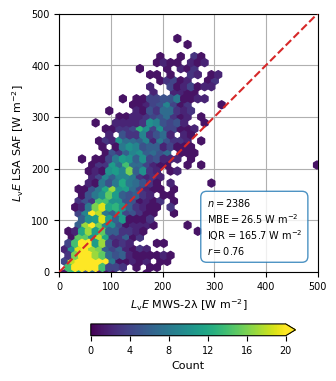

In [16]:
df_Nokia_meteo['RAIN_30min'] = df_Nokia_meteo['Cabauw:RAIN']*3
df_Nokia_meteo['RAIN_30min_prev'] = df_Nokia_meteo['RAIN_30min'].shift(1)
df_Nokia_meteo['RAIN_30min_prev2'] = df_Nokia_meteo['RAIN_30min'].shift(2)

df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min_prev']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min_prev2']>0.1/2] = np.nan

print_var = ['Cabauw:LEED','2Beam:LvE_MWS','Cabauw:u_perp','Cabauw:D010', 'Cabauw:F010', 'Cabauw:FG0_shift', 'Cabauw:HSON', 'Cabauw:LWD', 'Cabauw:LWU',
             'Cabauw:RAIN', 'Cabauw:RH002', 'Cabauw:R_net', 'Cabauw:SWD', 'Cabauw:SWU', 'Cabauw:TA000', 'Cabauw:TA002', 'Cabauw:TD002', 
             'Cabauw:USTAB', 'Cabauw:USTPR', 'Cabauw:ZMA']

df_Nokia_meteo[['Nokia_HPF_noise','Nokia_var_corr']].loc['2023-09-25 11:00':'2023-09-25 15:00'] = np.nan

#EC
df_Nokia_meteo['Cabauw:Bowen_day'] = df_Nokia_meteo['Cabauw:Bowen']
df_Nokia_meteo['Cabauw:Bowen_day'].loc[df_Nokia_meteo['Cabauw:SWD']<50] = np.nan
ave_Bowen = np.nanmedian(df_Nokia_meteo['Cabauw:Bowen_day'])
df_Nokia_meteo['Cabauw:LvE_Bowen'] = df_Nokia_meteo['Cabauw:R_G']/(1+ave_Bowen)
df_Nokia_meteo['Cabauw:H_Bowen'] = (df_Nokia_meteo['Cabauw:R_G']*ave_Bowen)/(1+ave_Bowen)

##############################################
#Latent heat flux
##############################################
fig,ax1 = plt.subplots(ncols = 1,nrows=1,figsize = (8/2.54,10/2.54),sharex=True,sharey=True)
# y_var = 'Cabauw:LvE_Bowen'
y_var = 'LSA:LvE'
x_var = '2Beam:LvE_MWS'
df_plot = df_Nokia_meteo[[x_var,y_var]].dropna(axis=0,how='any')

x,y = df_plot[x_var].values,df_plot[y_var].values
x_new = np.append(x,1000)
y_new = np.append(y,1000)
hb = ax1.hexbin(x_new,y_new,gridsize = 75,vmin = 0,vmax=20,zorder=3,mincnt=1)
corr,_ = pearsonr(y,x)
iq = np.quantile(y-x,0.9) - np.quantile(y-x,0.1)
bias = np.mean(y-x)
num = len(x)
textstr = '\n'.join((r'$n = $'+'{:.0f}'.format(num),r'$\mathrm{MBE} = $'+'{:.1f}'.format(bias)+' W m$^{-2}$',r'IQR = '+'{:.1f}'.format(iq)+' W m$^{-2}$',r'$r = $'+'{:.2f}'.format(corr)))                  
props = dict(boxstyle='round', facecolor='white',edgecolor='tab:blue', alpha=0.8, pad = 0.6)
ax1.text(0.94, 0.06, textstr, transform=ax1.transAxes, fontsize=7,verticalalignment='bottom',horizontalalignment='right',multialignment = 'left', bbox=props,zorder=6)
# ax1.set_xlabel(r'$L_{\mathrm{v}}E$ EC [W m$^{-2}$]',fontsize=8)
# ax1.set_ylabel(r'$L_{\mathrm{v}}E$ EBM-$\beta_{\mathrm{EC}}$ [W m$^{-2}$]',fontsize=8)
ax1.set_ylabel(r'$L_{\mathrm{v}}E$ LSA SAF [W m$^{-2}$]',fontsize=8)
ax1.set_xlabel(r'$L_{\mathrm{v}}E$ MWS-$2\mathrm{\lambda}$ [W m$^{-2}$]',fontsize=8)

for i in [ax1]:
    i.plot([0,1000],[0,1000],ls = '--',color = 'tab:red',label='1:1',zorder=6)
    i.grid(zorder=0)
    i.set_aspect('equal')
    i.tick_params(labelsize=7)
    i.set_xlim(0,500)
    i.set_ylim(0,500)

plt.subplots_adjust(left = 0.15,right = 0.97,top=0.98,bottom = 0.2)
cbar_ax = fig.add_axes([0.25, 0.1, 0.65, 0.03])
cbar = plt.colorbar(hb, cax=cbar_ax,extend = 'max',orientation = 'horizontal',ticks = [0,4,8,12,16,20])
cbar.set_label(label = 'Count',size = 8)
cbar_ax.tick_params(labelsize=7)
# plt.show()
save_figure('Figures/Evaporation_computation/Flux_'+x_var.replace(":", "_")+'_vs_'+y_var.replace(":", "_"),2400)
# save_figure_pdf('Figures/Evaporation_computation/Flux_'+x_var.replace(":", "_")+'_vs_'+y_var.replace(":", "_"))


### Daily rates

In [7]:
timestep = '30min'
df_mw_var = pd.HDFStore(path_to_proc_data+'var_'+timestep+'_timeseries_frequency_Nokia_corr_MWS_38GHz_24_02_LAS_EBM_FG0_shift_par_fixed_Bowen_LSA_z_0.h5',mode='r')['var_'+timestep] #Sept - October

size = 15
cp = 1006 #J kg-1 K-1
Lv = 2.3*10**6 #J kg-1
nan_filter = 0.25 #if more than this fraction is nans in the timeseries of the Nokia/MWS, timestep will be removed

df_scatter_Nokia = df_mw_var.copy()

df_scatter_Nokia['MWS_det'].loc[df_scatter_Nokia['MWS_det']>0.003] = np.nan
df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_var_corr']>6.49*10**-12] = np.nan
df_scatter_Nokia['MWS_HPF'].loc[df_scatter_Nokia['MWS_HPF']>6.49*10**-12] = np.nan
df_scatter_Nokia['EC_Cnn_10'].loc[df_scatter_Nokia['EC_Cnn_10']>6.49*10**-12] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_HPF_noise']>6.49*10**-12] = np.nan
df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_var_corr']<=0.] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_HPF_noise']<=0.] = np.nan
df_scatter_Nokia['MWS_HPF'].loc[df_scatter_Nokia['MWS_HPF']<=10**-18] = np.nan
df_scatter_Nokia['EC_Cnn_10'].loc[df_scatter_Nokia['EC_Cnn_10']<=0.] = np.nan
df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_nans']/(sr_Nokia*60*30) > nan_filter] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_nans']/(sr_Nokia*60*30) > nan_filter] = np.nan
df_scatter_Nokia['2Beam:LvE_Nokia_HPF_noise'] = df_scatter_Nokia['2Beam:LvE_CML1']
df_scatter_Nokia['2Beam:LvE_Nokia_var_corr'] = df_scatter_Nokia['2Beam:LvE_CML2']
df_scatter_Nokia['2Beam_FC:LvE_Nokia_HPF_noise'] = df_scatter_Nokia['2Beam_FC:LvE_CML1']
df_scatter_Nokia['2Beam_FC:LvE_Nokia_var_corr'] = df_scatter_Nokia['2Beam_FC:LvE_CML2']
df_scatter_Nokia['2Beam:H_Nokia_HPF_noise'] = df_scatter_Nokia['2Beam:H_CML1']
df_scatter_Nokia['2Beam:H_Nokia_var_corr'] = df_scatter_Nokia['2Beam:H_CML2']
df_scatter_Nokia['2Beam_FC:H_Nokia_HPF_noise'] = df_scatter_Nokia['2Beam_FC:H_CML1']
df_scatter_Nokia['2Beam_FC:H_Nokia_var_corr'] = df_scatter_Nokia['2Beam_FC:H_CML2']

df_Nokia_meteo = df_scatter_Nokia.copy()
df_Nokia_meteo = df_Nokia_meteo['2024-04-01':'2024-10-01']
print(sorted(list(df_Nokia_meteo.keys())))

['2Beam:C_TT_CML1', '2Beam:C_TT_CML2', '2Beam:C_TT_MWS', '2Beam:C_qq_CML1', '2Beam:C_qq_CML2', '2Beam:C_qq_MWS', '2Beam:H_CML1', '2Beam:H_CML2', '2Beam:H_MWS', '2Beam:H_Nokia_HPF_noise', '2Beam:H_Nokia_var_corr', '2Beam:K_CTT_CML1', '2Beam:K_CTT_CML2', '2Beam:K_CTT_MWS', '2Beam:K_Cqq_CML1', '2Beam:K_Cqq_CML2', '2Beam:K_Cqq_MWS', '2Beam:L_Ob_CML1', '2Beam:L_Ob_CML2', '2Beam:L_Ob_MWS', '2Beam:LvE_CML1', '2Beam:LvE_CML2', '2Beam:LvE_MWS', '2Beam:LvE_Nokia_HPF_noise', '2Beam:LvE_Nokia_var_corr', '2Beam:f_TT_10_CML1', '2Beam:f_TT_10_CML2', '2Beam:f_TT_10_MWS', '2Beam:f_qq_10_CML1', '2Beam:f_qq_10_CML2', '2Beam:f_qq_10_MWS', '2Beam:u_star_CML1', '2Beam:u_star_CML2', '2Beam:u_star_MWS', '2Beam_EC:H_CML1', '2Beam_EC:H_CML2', '2Beam_EC:H_MWS', '2Beam_EC:K_CTT', '2Beam_EC:K_Cqq', '2Beam_EC:LvE_CML1', '2Beam_EC:LvE_CML2', '2Beam_EC:LvE_MWS', '2Beam_FC:H_CML1', '2Beam_FC:H_CML2', '2Beam_FC:H_MWS', '2Beam_FC:H_Nokia_HPF_noise', '2Beam_FC:H_Nokia_var_corr', '2Beam_FC:LvE_CML1', '2Beam_FC:LvE_CML2', 

In [11]:
df_Nokia_meteo['RAIN_30min'] = df_Nokia_meteo['Cabauw:RAIN']*3
df_Nokia_meteo['RAIN_30min_prev'] = df_Nokia_meteo['RAIN_30min'].shift(1)
df_Nokia_meteo['RAIN_30min_prev2'] = df_Nokia_meteo['RAIN_30min'].shift(2)

df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min_prev']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min_prev2']>0.1/2] = np.nan

df_Nokia_meteo[['Nokia_HPF_noise','Nokia_var_corr']].loc['2023-09-25 11:00':'2023-09-25 15:00'] = np.nan

df_lve = df_Nokia_meteo[['2Beam:LvE_MWS','2Beam:LvE_Nokia_HPF_noise','2Beam:LvE_Nokia_var_corr','Cabauw:LEED',
                         'EBM:LvE_MWS_HPF','EBM:LvE_Nokia_HPF_noise','EBM:LvE_Nokia_var_corr',
                         '2Beam_FC:LvE_Nokia_HPF_noise','2Beam_FC:LvE_Nokia_var_corr',
                        'EBM_FC:LvE_MWS_HPF','EBM_FC:LvE_Nokia_HPF_noise','EBM_FC:LvE_Nokia_var_corr',
                        'Lv','EBM_LSA_FC:LvE_Nokia_HPF_noise','EBM_LSA_FC:LvE_Nokia_var_corr',
                         'EBM_LSA:LvE_Nokia_HPF_noise','EBM_LSA:LvE_Nokia_var_corr']].apply(pd.to_numeric)

rho_water = 1000 #kg m-3
for i in df_lve.keys():
    if i != 'Lv':
        df_lve[i] = (df_lve[i]/df_lve['Lv'])/rho_water*1800*1000

method = ['2Beam','2Beam_FC','EBM','EBM_FC','EBM_LSA','EBM_LSA_FC']
method_label = ['CML-$2\mathrm{\lambda}$','CML-$2\mathrm{\lambda}$-FC','CML-EBM','CML-EBM-FC','CML-EBM-LSA','CML-EBM-LSA-FC']

##############################################
#Latent heat flux
##############################################
for i in range(0,len(method)):
    y_var_indep = method[i]+':LvE_Nokia_HPF_noise'
    y_var_dep = method[i]+':LvE_Nokia_var_corr'
    fig,ax = plt.subplots(ncols = 2,nrows=2,figsize = (12/2.54,11/2.54),sharex=True,sharey=True)
    [ax1,ax2,ax3,ax4] = ax.ravel()
    
    #U independent versus MWS
    df_plot = df_lve[['2Beam:LvE_MWS',y_var_indep]]
    df_plot = df_plot.dropna(axis=0,how='any').resample('1D',label='left',closed='right').sum()
    df_plot.loc[(df_plot['2Beam:LvE_MWS'] == 0) & (df_plot[y_var_indep] == 0)] = np.nan
    df_plot = df_plot.dropna(axis=0,how='any')
    x,y = df_plot['2Beam:LvE_MWS'].values,df_plot[y_var_indep].values
    ax1.scatter(x,y,alpha=0.2,s = size,zorder=3)
    corr,_ = pearsonr(y,x)
    iq = np.quantile(y-x,0.9) - np.quantile(y-x,0.1)
    bias = np.mean(y-x)
    num = len(x)
    textstr = '\n'.join((r'$n = $'+'{:.0f}'.format(num),r'$\mathrm{MBE} = $'+'{:.2f}'.format(bias)+' mm d$^{-1}$',r'IQR = '+'{:.2f}'.format(iq)+' mm d$^{-1}$',r'$r$ = '+'{:.2f}'.format(corr)))                  
    props = dict(boxstyle='round', facecolor='white',edgecolor='tab:blue', alpha=0.8, pad = 0.6)
    ax1.text(0.94, 0.06, textstr, transform=ax1.transAxes, fontsize=7,verticalalignment='bottom',horizontalalignment='right',multialignment = 'left', bbox=props,zorder=6)
    ax1.set_title(r'Method 1: Constant noise',fontsize=8)
    ax1.set_xlabel(r'$E$ MWS-$2\mathrm{\lambda}$ [mm $\mathrm{d}^{-1}$]',fontsize=8)
    ax1.set_ylabel(r'$E$ '+method_label[i]+r' [mm $\mathrm{d}^{-1}$]',fontsize=8)
    
    #U dependent versus MWS
    df_plot = df_lve[['2Beam:LvE_MWS',y_var_dep]]
    df_plot = df_plot.dropna(axis=0,how='any').resample('1D',label='left',closed='right').sum()
    df_plot.loc[(df_plot['2Beam:LvE_MWS'] == 0) & (df_plot[y_var_dep] == 0)] = np.nan
    df_plot = df_plot.dropna(axis=0,how='any')
    x,y = df_plot['2Beam:LvE_MWS'].values,df_plot[y_var_dep].values
    ax2.scatter(x,y,alpha=0.2,s = size,zorder=3)
    corr,_ = pearsonr(y,x)
    iq = np.quantile(y-x,0.9) - np.quantile(y-x,0.1)
    bias = np.mean(y-x)
    num = len(x)
    textstr = '\n'.join((r'$n = $'+'{:.0f}'.format(num),r'$\mathrm{MBE} = $'+'{:.2f}'.format(bias)+' mm d$^{-1}$',r'IQR = '+'{:.2f}'.format(iq)+' mm d$^{-1}$',r'$r$ = '+'{:.2f}'.format(corr)))                   
    ax2.text(0.94, 0.06, textstr, transform=ax2.transAxes, fontsize=7,verticalalignment='bottom',horizontalalignment='right',multialignment = 'left', bbox=props,zorder=6)
    ax2.set_title(r'Method 2: Spectral noise',fontsize=8)
    ax2.set_xlabel(r'$E$ MWS-$2\mathrm{\lambda}$ [mm $\mathrm{d}^{-1}$]',fontsize=8)
    
    #U independent versus EC
    df_plot = df_lve[['Cabauw:LEED',y_var_indep]]
    df_plot = df_plot.dropna(axis=0,how='any').resample('1D',label='left',closed='right').sum()
    df_plot.loc[(df_plot['Cabauw:LEED'] == 0) & (df_plot[y_var_indep] == 0)] = np.nan
    df_plot = df_plot.dropna(axis=0,how='any')
    x,y = df_plot['Cabauw:LEED'].values,df_plot[y_var_indep].values
    ax3.scatter(x,y,alpha=0.2,s = size,zorder=3)
    corr,_ = pearsonr(y,x)
    iq = np.quantile(y-x,0.9) - np.quantile(y-x,0.1)
    bias = np.mean(y-x)
    num = len(x)
    textstr = '\n'.join((r'$n = $'+'{:.0f}'.format(num),r'$\mathrm{MBE} = $'+'{:.2f}'.format(bias)+' mm d$^{-1}$',r'IQR = '+'{:.2f}'.format(iq)+' mm d$^{-1}$',r'$r$ = '+'{:.2f}'.format(corr)))                                  
    ax3.text(0.94, 0.06, textstr, transform=ax3.transAxes, fontsize=7,verticalalignment='bottom',horizontalalignment='right',multialignment = 'left', bbox=props,zorder=6)
    ax3.set_xlabel(r'$E$ EC [mm $\mathrm{d}^{-1}$]',fontsize=8)
    ax3.set_ylabel(r'$E$ '+method_label[i]+r' [mm $\mathrm{d}^{-1}$]',fontsize=8)
    
    #U dependent versus EC
    df_plot = df_lve[['Cabauw:LEED',y_var_dep]]
    df_plot = df_plot.dropna(axis=0,how='any').resample('1D',label='left',closed='right').sum()
    df_plot.loc[(df_plot['Cabauw:LEED'] == 0) & (df_plot[y_var_dep] == 0)] = np.nan
    df_plot = df_plot.dropna(axis=0,how='any')
    x,y = df_plot['Cabauw:LEED'].values,df_plot[y_var_dep].values
    ax4.scatter(x,y,alpha=0.2,s = size,zorder=3)
    corr,_ = pearsonr(y,x)
    iq = np.quantile(y-x,0.9) - np.quantile(y-x,0.1)
    bias = np.mean(y-x)
    num = len(x)
    textstr = '\n'.join((r'$n = $'+'{:.0f}'.format(num),r'$\mathrm{MBE} = $'+'{:.2f}'.format(bias)+' mm d$^{-1}$',r'IQR = '+'{:.2f}'.format(iq)+' mm d$^{-1}$',r'$r$ = '+'{:.2f}'.format(corr)))                  
    ax4.text(0.94, 0.06, textstr, transform=ax4.transAxes, fontsize=7,verticalalignment='bottom',horizontalalignment='right',multialignment = 'left', bbox=props,zorder=6)
    ax4.set_xlabel(r'$E$ EC [mm $\mathrm{d}^{-1}$]',fontsize=8)
    
    for j in [ax1,ax2,ax3,ax4]:
        j.plot([0,1000],[0,1000],ls = '--',color = 'tab:red',label='1:1')
        j.grid(zorder=0)
        j.set_aspect('equal')
        j.tick_params(labelsize=7)
        j.set_xlim(0,5)
        j.set_ylim(0,5)
    
    ax1.text(0.05, 0.9, '(a)', transform=ax1.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
    ax2.text(0.05, 0.9, '(b)', transform=ax2.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
    ax3.text(0.05, 0.9, '(c)', transform=ax3.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
    ax4.text(0.05, 0.9, '(d)', transform=ax4.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
    
    plt.subplots_adjust(left = 0.13,right=0.95,top = 0.94,bottom = 0.1,wspace=0.3,hspace = 0.2)
    # plt.show()
    save_figure('Figures/Evaporation_computation/Flux_daily_'+method[i],2400)
    # save_figure_pdf('Figures/Evaporation_computation/Flux_daily_'+method[i])
    plt.close()


### Timeseries

In [4]:
timestep = '30min'
df_mw_var = pd.HDFStore(path_to_proc_data+'var_'+timestep+'_timeseries_frequency_Nokia_corr_MWS_38GHz_24_02_LAS_EBM_FG0_shift_par_fixed_Bowen_LSA_z_0.h5',mode='r')['var_'+timestep] #Sept - October

size = 15

cp = 1006 #J kg-1 K-1
Lv = 2.3*10**6 #J kg-1
nan_filter = 0.25 #if more than this fraction is nans in the timeseries of the Nokia/MWS, timestep will be removed

df_scatter_Nokia = df_mw_var.copy()
df_scatter_Nokia['MWS_det'].loc[df_scatter_Nokia['MWS_det']>0.003] = np.nan
df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_var_corr']>6.49*10**-12] = np.nan
df_scatter_Nokia['MWS_HPF'].loc[df_scatter_Nokia['MWS_HPF']>6.49*10**-12] = np.nan
df_scatter_Nokia['EC_Cnn_10'].loc[df_scatter_Nokia['EC_Cnn_10']>6.49*10**-12] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_HPF_noise']>6.49*10**-12] = np.nan
df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_var_corr']<=0.] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_HPF_noise']<=0.] = np.nan
df_scatter_Nokia['MWS_HPF'].loc[df_scatter_Nokia['MWS_HPF']<=10**-18] = np.nan
df_scatter_Nokia['EC_Cnn_10'].loc[df_scatter_Nokia['EC_Cnn_10']<=0.] = np.nan
df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_nans']/(sr_Nokia*60*30) > nan_filter] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_nans']/(sr_Nokia*60*30) > nan_filter] = np.nan
df_scatter_Nokia['T_term'] = (df_scatter_Nokia['AT_MWS']**2)/(df_scatter_Nokia['Cabauw:TA002']**2)*df_scatter_Nokia['2Beam:C_TT_MWS']
df_scatter_Nokia['q_term'] = (df_scatter_Nokia['Aq_MWS']**2)/(df_scatter_Nokia['q_EC']**2)*df_scatter_Nokia['2Beam:C_qq_MWS']
# df_scatter_Nokia['Tq_term'] = (df_scatter_Nokia['Aq_MWS']*df_scatter_Nokia['AT_MWS'])/(df_scatter_Nokia['q_EC']*df_scatter_Nokia['Cabauw:TA002'])*df_scatter_Nokia['2Beam:C_Tq_MWS']

df_Nokia_meteo = df_scatter_Nokia.copy()
df_Nokia_meteo = df_Nokia_meteo['2024-04-01':'2024-10-01']
print(sorted(list(df_Nokia_meteo.keys())))


['2Beam:C_TT_CML1', '2Beam:C_TT_CML2', '2Beam:C_TT_MWS', '2Beam:C_qq_CML1', '2Beam:C_qq_CML2', '2Beam:C_qq_MWS', '2Beam:H_CML1', '2Beam:H_CML2', '2Beam:H_MWS', '2Beam:K_CTT_CML1', '2Beam:K_CTT_CML2', '2Beam:K_CTT_MWS', '2Beam:K_Cqq_CML1', '2Beam:K_Cqq_CML2', '2Beam:K_Cqq_MWS', '2Beam:L_Ob_CML1', '2Beam:L_Ob_CML2', '2Beam:L_Ob_MWS', '2Beam:LvE_CML1', '2Beam:LvE_CML2', '2Beam:LvE_MWS', '2Beam:f_TT_10_CML1', '2Beam:f_TT_10_CML2', '2Beam:f_TT_10_MWS', '2Beam:f_qq_10_CML1', '2Beam:f_qq_10_CML2', '2Beam:f_qq_10_MWS', '2Beam:u_star_CML1', '2Beam:u_star_CML2', '2Beam:u_star_MWS', '2Beam_EC:H_CML1', '2Beam_EC:H_CML2', '2Beam_EC:H_MWS', '2Beam_EC:K_CTT', '2Beam_EC:K_Cqq', '2Beam_EC:LvE_CML1', '2Beam_EC:LvE_CML2', '2Beam_EC:LvE_MWS', '2Beam_FC:H_CML1', '2Beam_FC:H_CML2', '2Beam_FC:H_MWS', '2Beam_FC:LvE_CML1', '2Beam_FC:LvE_CML2', '2Beam_FC:LvE_MWS', 'AT_LAS', 'AT_MWS', 'AT_fixed', 'Aq_LAS', 'Aq_MWS', 'Aq_fixed', 'CAMS:BHI', 'CAMS:CLEAR_SKY_BHI', 'CAMS:Cloud_cover', 'CAMS:DHI', 'CAMS:GHI', 'C_TT_L

2024-05-11 05:00:00    41.572744
2024-05-11 05:30:00    -0.816678
2024-05-11 06:00:00     6.785342
2024-05-11 06:30:00   -25.261035
2024-05-11 07:00:00    -14.91715
2024-05-11 07:30:00   -20.464828
2024-05-11 08:00:00   -33.161868
2024-05-11 08:30:00   -37.368777
2024-05-11 09:00:00   -36.581685
2024-05-11 09:30:00   -67.250729
2024-05-11 10:00:00   -81.228071
2024-05-11 10:30:00   -70.698354
2024-05-11 11:00:00    -67.90005
2024-05-11 11:30:00   -68.642227
2024-05-11 12:00:00    -64.75494
2024-05-11 12:30:00     -78.4352
2024-05-11 13:00:00   -81.957015
2024-05-11 13:30:00    -66.77682
2024-05-11 14:00:00   -39.545985
2024-05-11 14:30:00    22.843407
2024-05-11 15:00:00   -57.389366
2024-05-11 15:30:00    -37.52227
2024-05-11 16:00:00   -32.812589
2024-05-11 16:30:00   -25.057232
2024-05-11 17:00:00     66.54271
2024-05-11 17:30:00    30.357295
2024-05-11 18:00:00    72.465499
2024-05-11 18:30:00    95.279453
dtype: object


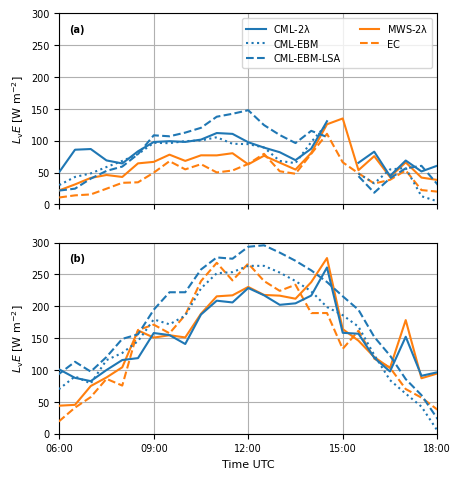

In [6]:
fig,[ax1,ax2] = plt.subplots(ncols = 1,nrows=2,figsize = (12/2.54,12/2.54))

colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c']
lw = 1.5
color_CML = 'tab:blue'
color_ref = 'tab:orange'
df_Nokia_meteo = df_Nokia_meteo.loc[df_Nokia_meteo['Cabauw:SWD']>50]
df_ax_14 = df_Nokia_meteo[['2Beam:LvE_CML2','EBM:LvE_Nokia_var_corr','EBM_LSA:LvE_Nokia_var_corr','2Beam:LvE_MWS','Cabauw:LEED']]['2024-05-08 00:00':'2024-05-09 00:00']
Nokia_2Beam = df_ax_14['2Beam:LvE_CML2']
Nokia_EBM = df_ax_14['EBM:LvE_Nokia_var_corr']
Nokia_EBM_LSA = df_ax_14['EBM_LSA:LvE_Nokia_var_corr']
MWS = df_ax_14['2Beam:LvE_MWS']
EC = df_ax_14['Cabauw:LEED']
ax1.plot(Nokia_2Beam.index,Nokia_2Beam.values,color = color_CML,label = r'CML-$2\mathrm{\lambda}$',lw=lw,ls='-',zorder=4)
ax1.plot(Nokia_EBM.index,Nokia_EBM.values,color = color_CML,label = r'CML-EBM',lw=lw,ls=':',zorder=4)
ax1.plot(Nokia_EBM_LSA.index,Nokia_EBM_LSA.values,color = color_CML,label = r'CML-EBM-LSA',lw=lw,ls='--',zorder=4)
ax1.plot(MWS.index,MWS.values,color = color_ref,label = 'MWS-$2\mathrm{\lambda}$',lw=lw,ls='-',zorder=3)
ax1.plot(EC.index,EC.values,color = color_ref,label = 'EC',lw=lw,ls='--',zorder=3)
ax1.grid(zorder=0)
ax1.set_ylim(0,300)
ax1.set_xlim(pd.to_datetime('2024-05-08 06:00'),pd.to_datetime('2024-05-08 18:00'))
ax1.set_ylabel(r'$L_{\mathrm{v}}E$ [W $\mathrm{m}^{-2}$]',fontsize=8)


df_ax_08 = df_Nokia_meteo[['2Beam:LvE_CML2','EBM:LvE_Nokia_var_corr','EBM_LSA:LvE_Nokia_var_corr','2Beam:LvE_MWS','Cabauw:LEED']]['2024-05-11 00:00':'2024-05-12 00:00']
print(df_ax_08['2Beam:LvE_CML2'] - df_ax_08['EBM_LSA:LvE_Nokia_var_corr'])
Nokia_2Beam = df_ax_08['2Beam:LvE_CML2']
Nokia_EBM_LSA = df_ax_08['EBM_LSA:LvE_Nokia_var_corr']
Nokia_EBM = df_ax_08['EBM:LvE_Nokia_var_corr']
MWS = df_ax_08['2Beam:LvE_MWS']
EC = df_ax_08['Cabauw:LEED']
ax2.plot(Nokia_2Beam.index,Nokia_2Beam.values,color = color_CML,label = r'CML-$2\mathrm{\lambda}$',lw=lw,ls='-',zorder=4)
ax2.plot(Nokia_EBM.index,Nokia_EBM.values,color = color_CML,label = r'CML-EBM',lw=lw,ls=':',zorder=4)
ax2.plot(Nokia_EBM_LSA.index,Nokia_EBM_LSA.values,color = color_CML,label = r'CML-EBM-LSA',lw=lw,ls='--',zorder=4)
ax2.plot(MWS.index,MWS.values,color = color_ref,label = 'MWS-$2\mathrm{\lambda}$',lw=lw,ls='-',zorder=3)
ax2.plot(EC.index,EC.values,color = color_ref,label = 'EC',lw=lw,ls='--',zorder=3)
ax2.grid(zorder=0)
ax2.set_ylim(0,300)
ax2.set_xlim(pd.to_datetime('2024-05-11 06:00'),pd.to_datetime('2024-05-11 18:00'))

ax2.set_xlabel(r'Time UTC',fontsize=8)
ax2.set_ylabel(r'$L_{\mathrm{v}}E$ [W $\mathrm{m}^{-2}$]',fontsize=8)
ax1.text(0.025, 0.9, '(a)', transform=ax1.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
ax2.text(0.025, 0.9, '(b)', transform=ax2.transAxes, fontsize=7,fontweight='semibold',zorder=11) 

ax1.tick_params(labelsize = 7,labelbottom=False)
ax2.tick_params(labelsize = 7)
ticks = pd.date_range(start = '2024-05-11 06:00',end = '2024-05-11 18:00', periods = 5).strftime('%Y-%m-%d %H:%M:%S')
tick_labels = pd.date_range(start = '2024-05-11 06:00',end = '2024-05-11 18:00', periods = 5).strftime('%H:%M')
ax2.set_xticks(ticks)
ax2.set_xticklabels(tick_labels,fontsize=7)#, va = ticklabel_va)
ticks = pd.date_range(start = '2024-05-08 06:00',end = '2024-05-08 18:00', periods = 5).strftime('%Y-%m-%d %H:%M:%S')
tick_labels = pd.date_range(start = '2024-05-08 06:00',end = '2024-05-08 18:00', periods = 5).strftime('%H:%M')
ax1.set_xticks(ticks)
ax1.set_xticklabels(tick_labels,fontsize=7)#, va = ticklabel_va)
ax1.legend(fontsize=7,loc=1,ncol=2)

fig.align_ylabels()
plt.subplots_adjust(left=0.15,right=0.95,top=0.97,bottom=0.08,hspace=0.2)
save_figure_pdf('Figures/Evaporation_computation/Flux_timeseries')

## Statistic plots

In [42]:
timestep = '30min'
df_mw_var = pd.HDFStore(path_to_proc_data+'var_'+timestep+'_timeseries_frequency_Nokia_corr_MWS_38GHz_24_02_LAS_EBM_FG0_shift_par_fixed_Bowen_LSA_z_0.h5',mode='r')['var_'+timestep] #April- Oct 2024
size = 15
cp = 1006 #J kg-1 K-1
Lv = 2.3*10**6 #J kg-1
nan_filter = 0.25 #if more than this fraction is nans in the timeseries of the Nokia/MWS, timestep will be removed

df_scatter_Nokia = df_mw_var.copy()
df_scatter_Nokia['MWS_det'].loc[df_scatter_Nokia['MWS_det']>0.003] = np.nan
df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_var_corr']>6.49*10**-12] = np.nan
df_scatter_Nokia['MWS_HPF'].loc[df_scatter_Nokia['MWS_HPF']>6.49*10**-12] = np.nan
df_scatter_Nokia['EC_Cnn_10'].loc[df_scatter_Nokia['EC_Cnn_10']>6.49*10**-12] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_HPF_noise']>6.49*10**-12] = np.nan
df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_var_corr']<=0.] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_HPF_noise']<=0.] = np.nan
df_scatter_Nokia['MWS_HPF'].loc[df_scatter_Nokia['MWS_HPF']<=10**-18] = np.nan
df_scatter_Nokia['EC_Cnn_10'].loc[df_scatter_Nokia['EC_Cnn_10']<=0.] = np.nan
df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_nans']/(sr_Nokia*60*30) > nan_filter] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_nans']/(sr_Nokia*60*30) > nan_filter] = np.nan

df_Nokia_meteo = df_scatter_Nokia.copy()
df_Nokia_meteo = df_Nokia_meteo['2024-04-01':'2024-10-01']
print(sorted(list(df_Nokia_meteo.keys())))

['2Beam:C_TT_CML1', '2Beam:C_TT_CML2', '2Beam:C_TT_MWS', '2Beam:C_qq_CML1', '2Beam:C_qq_CML2', '2Beam:C_qq_MWS', '2Beam:H_CML1', '2Beam:H_CML2', '2Beam:H_MWS', '2Beam:K_CTT_CML1', '2Beam:K_CTT_CML2', '2Beam:K_CTT_MWS', '2Beam:K_Cqq_CML1', '2Beam:K_Cqq_CML2', '2Beam:K_Cqq_MWS', '2Beam:L_Ob_CML1', '2Beam:L_Ob_CML2', '2Beam:L_Ob_MWS', '2Beam:LvE_CML1', '2Beam:LvE_CML2', '2Beam:LvE_MWS', '2Beam:f_TT_10_CML1', '2Beam:f_TT_10_CML2', '2Beam:f_TT_10_MWS', '2Beam:f_qq_10_CML1', '2Beam:f_qq_10_CML2', '2Beam:f_qq_10_MWS', '2Beam:u_star_CML1', '2Beam:u_star_CML2', '2Beam:u_star_MWS', '2Beam_EC:H_CML1', '2Beam_EC:H_CML2', '2Beam_EC:H_MWS', '2Beam_EC:K_CTT', '2Beam_EC:K_Cqq', '2Beam_EC:LvE_CML1', '2Beam_EC:LvE_CML2', '2Beam_EC:LvE_MWS', '2Beam_FC:H_CML1', '2Beam_FC:H_CML2', '2Beam_FC:H_MWS', '2Beam_FC:LvE_CML1', '2Beam_FC:LvE_CML2', '2Beam_FC:LvE_MWS', 'AT_LAS', 'AT_MWS', 'AT_fixed', 'Aq_LAS', 'Aq_MWS', 'Aq_fixed', 'CAMS:BHI', 'CAMS:CLEAR_SKY_BHI', 'CAMS:Cloud_cover', 'CAMS:DHI', 'CAMS:GHI', 'C_TT_L

##### LvE (First run previous cell)

0.24822083
2Beam
48.08523885133255 133.797613298987
8.248537493133563 82.48761587407773
EBM
20.774613012474983 125.41654233242502
26.477324557406927 136.93951130116307
EBM_LSA
33.42818791421269 168.65704747861315
41.82551622586967 183.44647894004436
0.8174102829766006 71.37047518156913 29.198179539098025


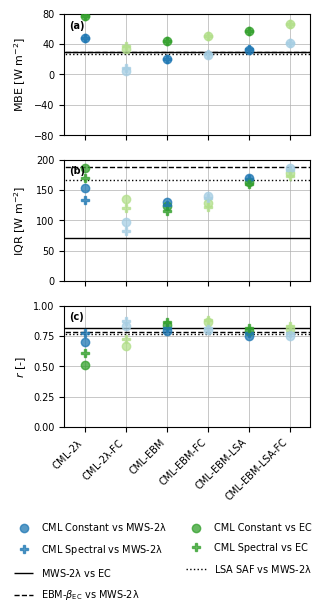

In [44]:
df_Nokia_meteo['RAIN_30min'] = df_Nokia_meteo['Cabauw:RAIN']*3
df_Nokia_meteo['RAIN_30min_prev'] = df_Nokia_meteo['RAIN_30min'].shift(1)
df_Nokia_meteo['RAIN_30min_prev2'] = df_Nokia_meteo['RAIN_30min'].shift(2)

df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min_prev']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min_prev2']>0.1/2] = np.nan

df_Nokia_meteo[['Nokia_HPF_noise','Nokia_var_corr']].loc['2023-09-25 11:00':'2023-09-25 15:00'] = np.nan
df_Nokia_meteo['2Beam:LvE_Nokia_HPF_noise'] = df_Nokia_meteo['2Beam:LvE_CML1']
df_Nokia_meteo['2Beam:LvE_Nokia_var_corr'] = df_Nokia_meteo['2Beam:LvE_CML2']
df_Nokia_meteo['2Beam_FC:LvE_Nokia_HPF_noise'] = df_Nokia_meteo['2Beam_FC:LvE_CML1']
df_Nokia_meteo['2Beam_FC:LvE_Nokia_var_corr'] = df_Nokia_meteo['2Beam_FC:LvE_CML2']
df_Nokia_meteo['2Beam:H_Nokia_HPF_noise'] = df_Nokia_meteo['2Beam:H_CML1']
df_Nokia_meteo['2Beam:H_Nokia_var_corr'] = df_Nokia_meteo['2Beam:H_CML2']
df_Nokia_meteo['2Beam_FC:H_Nokia_HPF_noise'] = df_Nokia_meteo['2Beam_FC:H_CML1']
df_Nokia_meteo['2Beam_FC:H_Nokia_var_corr'] = df_Nokia_meteo['2Beam_FC:H_CML2']


methods = ['2Beam','EBM','EBM_LSA']
methods_label = [r'CML-$2\mathrm{\lambda}$',r'CML-$2\mathrm{\lambda}$-FC','CML-EBM','CML-EBM-FC','CML-EBM-LSA','CML-EBM-LSA-FC']#,'LSA-$\\beta$']#,'MWS-LAS vs EC']

props = dict(boxstyle='round', facecolor='white',edgecolor='tab:blue', alpha=0.5, pad = 0.6)
colors = ['#1f78b4','#a6cee3','#33a02c','#b2df8a']
alpha = 0.75
plot_offset = 0.25

def stats(x,y):
    corr,_ = pearsonr(y.values,x.values)
    iq = np.quantile(y.values-x.values,0.9) - np.quantile(y.values-x.values,0.1)
    bias = np.mean(y.values-x.values)
    return corr,iq,bias

#Estimate LvE using EC
df_Nokia_meteo['Cabauw:Bowen_day'] = df_Nokia_meteo['Cabauw:Bowen']
df_Nokia_meteo['Cabauw:Bowen_day'].loc[df_Nokia_meteo['Cabauw:SWD']<50] = np.nan
ave_Bowen = np.nanmedian(df_Nokia_meteo['Cabauw:Bowen_day'])
df_Nokia_meteo['Cabauw:LvE_Bowen'] = df_Nokia_meteo['Cabauw:R_G']/(1+ave_Bowen)
df_Nokia_meteo['Cabauw:H_Bowen'] = (df_Nokia_meteo['Cabauw:R_G']*ave_Bowen)/(1+ave_Bowen)

##############################################
#Latent heat flux
##############################################

fig,[ax1,ax2,ax3] = plt.subplots(ncols = 1,nrows=3,figsize = (8/2.54,15/2.54),sharex=True) #was 14 height

var_MWS = 'LvE_MWS'
var_EC = 'LEED'
for i in range(0,len(methods)):
    print(methods[i])
    for j in range(0,2):
        if j == 0:
            y_var_indep = methods[i]+':LvE_Nokia_HPF_noise'
            y_var_dep = methods[i]+':LvE_Nokia_var_corr'
            offset = -1*plot_offset
            c = 0
        else:
            y_var_indep = methods[i]+'_FC:LvE_Nokia_HPF_noise'
            y_var_dep = methods[i]+'_FC:LvE_Nokia_var_corr'
            offset = plot_offset
            c = 1
            
        df_plot = df_Nokia_meteo[['2Beam:'+var_MWS,y_var_indep]].dropna(axis=0,how='any')
        x,y = df_plot['2Beam:'+var_MWS],df_plot[y_var_indep]
        corr,iq,bias = stats(x,y)
        ax1.plot(i+offset,bias,marker = 'o',lw = 0,color = colors[0+c],alpha=alpha,zorder=4)
        ax2.plot(i+offset,iq,marker = 'o',lw = 0,color = colors[0+c],alpha=alpha,zorder=4)
        ax3.plot(i+offset,corr,marker = 'o',lw = 0,color = colors[0+c],alpha=alpha,zorder=4)

        df_plot = df_Nokia_meteo[['Cabauw:'+var_EC,y_var_indep]].dropna(axis=0,how='any')
        x,y = df_plot['Cabauw:'+var_EC],df_plot[y_var_indep]
        corr,iq,bias = stats(x,y)
        ax1.plot(i+offset,bias,marker = 'o',lw = 0,color = colors[2+c],alpha=alpha,zorder=4)
        ax2.plot(i+offset,iq,marker = 'o',lw = 0,color = colors[2+c],alpha=alpha,zorder=4)
        ax3.plot(i+offset,corr,marker = 'o',lw = 0,color = colors[2+c],alpha=alpha,zorder=4)

        df_plot = df_Nokia_meteo[['2Beam:'+var_MWS,y_var_dep]].dropna(axis=0,how='any')
        x,y = df_plot['2Beam:'+var_MWS],df_plot[y_var_dep]
        corr,iq,bias = stats(x,y)
        print(bias,iq)
        ax1.plot(i+offset,bias,marker = 'P',lw = 0,color = colors[0+c],alpha=alpha,zorder=4)
        ax2.plot(i+offset,iq,marker = 'P',lw = 0,color = colors[0+c],alpha=alpha,zorder=4)
        ax3.plot(i+offset,corr,marker = 'P',lw = 0,color = colors[0+c],alpha=alpha,zorder=4)

        df_plot = df_Nokia_meteo[['Cabauw:'+var_EC,y_var_dep]].dropna(axis=0,how='any')
        x,y = df_plot['Cabauw:'+var_EC],df_plot[y_var_dep]
        corr,iq,bias = stats(x,y)
        ax1.plot(i+offset,bias,marker = 'P',lw = 0,color = colors[2+c],alpha=alpha,zorder=4)
        ax2.plot(i+offset,iq,marker = 'P',lw = 0,color = colors[2+c],alpha=alpha,zorder=4)
        ax3.plot(i+offset,corr,marker = 'P',lw = 0,color = colors[2+c],alpha=alpha,zorder=4)

ax3.plot(-5,-5,marker = 'o',lw = 0,color= colors[0],alpha=alpha,label = 'CML Constant vs MWS-$2\mathrm{\lambda}$')
ax3.plot(-5,-5,marker = 'P',lw = 0,color= colors[0],alpha=alpha,label = 'CML Spectral vs MWS-$2\mathrm{\lambda}$')
ax3.hlines(-10,-500,500,lw=1,ls='-',color='k',label = 'MWS-$2\mathrm{\lambda}$ vs EC')
ax3.hlines(-10,-500,500,lw=1,ls='--',color='k',label = r'EBM-$\beta_{\mathrm{EC}}$ vs MWS-$2\mathrm{\lambda}$')
ax3.plot(-5,-5,marker = 'o',lw = 0,color= colors[2],alpha=alpha,label = 'CML Constant vs EC')
ax3.plot(-5,-5,marker = 'P',lw = 0,color= colors[2],alpha=alpha,label = 'CML Spectral vs EC')
ax3.hlines(-10,-500,500,lw=1,ls=':',color='k',label = r'LSA SAF vs MWS-$2\mathrm{\lambda}$')

df_plot = df_Nokia_meteo[['2Beam:'+var_MWS,'Cabauw:'+var_EC]].dropna(axis=0,how='any')
y,x = df_plot['2Beam:'+var_MWS],df_plot['Cabauw:'+var_EC]
corr,iq,bias = stats(x,y)
print(corr,iq,bias)
ax1.hlines(bias,-500,500,lw=1,ls='-',color='k',zorder=3)
ax2.hlines(iq,-500,500,lw=1,ls='-',color='k',zorder=3)
ax3.hlines(corr,-500,500,lw=1,ls='-',color='k',zorder=3)

df_plot = df_Nokia_meteo[['2Beam:'+var_MWS,'Cabauw:LvE_Bowen']].dropna(axis=0,how='any')
x,y = df_plot['2Beam:'+var_MWS],df_plot['Cabauw:LvE_Bowen']
corr,iq,bias = stats(x,y)
ax1.hlines(bias,-500,500,lw=1,ls='--',color='k',zorder=3)
ax2.hlines(iq,-500,500,lw=1,ls='--',color='k',zorder=3)
ax3.hlines(corr,-500,500,lw=1,ls='--',color='k',zorder=3)

df_plot = df_Nokia_meteo[['2Beam:'+var_MWS,'LSA:LvE']].dropna(axis=0,how='any')
x,y = df_plot['2Beam:'+var_MWS],df_plot['LSA:LvE']
corr,iq,bias = stats(x,y)
ax1.hlines(bias,-500,500,lw=1,ls=':',color='k',zorder=3)
ax2.hlines(iq,-500,500,lw=1,ls=':',color='k',zorder=3)
ax3.hlines(corr,-500,500,lw=1,ls=':',color='k',zorder=3)

ax1.set_ylabel(r'MBE [W m$^{-2}$]',fontsize=8)
ax2.set_ylabel(r'IQR [W m$^{-2}$]',fontsize=8)
ax3.set_ylabel(r'$r$ [-]',fontsize=8)
ax1.set_ylim(-80,80)
ax1.set_yticks([-80,-40,0,40,80])
ax2.set_ylim(0,200)
ax2.set_yticks([0,50,100,150,200])
ax3.set_ylim(0,1)
ax3.set_yticks([0,.25,0.5,0.75,1])

for i in [ax1,ax2,ax3]:
    i.grid(lw=0.5)
    i.tick_params(labelsize=7)

ax3.set_xlim(-0.5,2.5)
ax3.set_xticks([0-offset,0+offset,1-offset,1+offset,2-offset,2+offset])
ax3.set_xticklabels(methods_label,rotation = 45,ha = 'right')

ax1.text(0.02, 0.88, '(a)', transform=ax1.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
ax2.text(0.02, 0.88, '(b)', transform=ax2.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
ax3.text(0.02, 0.88, '(c)', transform=ax3.transAxes, fontsize=7,fontweight='semibold',zorder=11) 

plt.subplots_adjust(left = 0.2,right=0.98,top = 0.98,bottom = 0.28,wspace=0.3,hspace = 0.2)
ax3.legend(bbox_to_anchor=(0.4,-0.7),fontsize=7,loc='upper center',ncol = 2,labelspacing = 1,frameon=False)
fig.align_ylabels()
# plt.show()
save_figure('Figures/Evaporation_computation/Statistics_LvE',2400)
# save_figure_pdf('Figures/Evaporation_computation/Statistics_LvE')

##### H

0.24822083


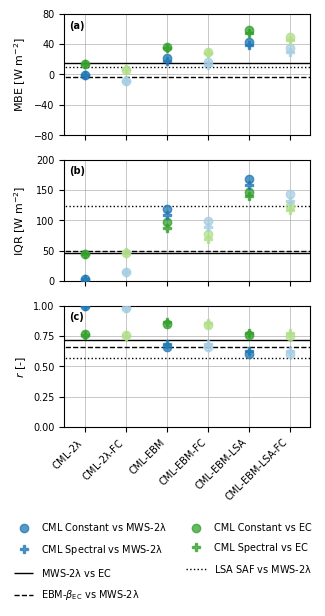

In [46]:
df_Nokia_meteo['RAIN_30min'] = df_Nokia_meteo['Cabauw:RAIN']*3
df_Nokia_meteo['RAIN_30min_prev'] = df_Nokia_meteo['RAIN_30min'].shift(1)
df_Nokia_meteo['RAIN_30min_prev2'] = df_Nokia_meteo['RAIN_30min'].shift(2)
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min_prev']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min_prev2']>0.1/2] = np.nan

df_Nokia_meteo[['Nokia_HPF_noise','Nokia_var_corr']].loc['2023-09-25 11:00':'2023-09-25 15:00'] = np.nan
df_Nokia_meteo['2Beam:LvE_Nokia_HPF_noise'] = df_Nokia_meteo['2Beam:LvE_CML1']
df_Nokia_meteo['2Beam:LvE_Nokia_var_corr'] = df_Nokia_meteo['2Beam:LvE_CML2']
df_Nokia_meteo['2Beam_FC:LvE_Nokia_HPF_noise'] = df_Nokia_meteo['2Beam_FC:LvE_CML1']
df_Nokia_meteo['2Beam_FC:LvE_Nokia_var_corr'] = df_Nokia_meteo['2Beam_FC:LvE_CML2']
df_Nokia_meteo['2Beam:H_Nokia_HPF_noise'] = df_Nokia_meteo['2Beam:H_CML1']
df_Nokia_meteo['2Beam:H_Nokia_var_corr'] = df_Nokia_meteo['2Beam:H_CML2']
df_Nokia_meteo['2Beam_FC:H_Nokia_HPF_noise'] = df_Nokia_meteo['2Beam_FC:H_CML1']
df_Nokia_meteo['2Beam_FC:H_Nokia_var_corr'] = df_Nokia_meteo['2Beam_FC:H_CML2']


methods = ['2Beam','EBM','EBM_LSA']
methods_label = [r'CML-$2\mathrm{\lambda}$',r'CML-$2\mathrm{\lambda}$-FC','CML-EBM','CML-EBM-FC','CML-EBM-LSA','CML-EBM-LSA-FC']

props = dict(boxstyle='round', facecolor='white',edgecolor='tab:blue', alpha=0.5, pad = 0.6)
colors = ['#1f78b4','#a6cee3','#33a02c','#b2df8a']
alpha = 0.75
plot_offset = 0.25

def stats(x,y):
    corr,_ = pearsonr(y.values,x.values)
    iq = np.quantile(y.values-x.values,0.9) - np.quantile(y.values-x.values,0.1)
    bias = np.mean(y.values-x.values)
    return corr,iq,bias

#Estimate LvE using EC
df_Nokia_meteo['Cabauw:Bowen_day'] = df_Nokia_meteo['Cabauw:Bowen']
df_Nokia_meteo['Cabauw:Bowen_day'].loc[df_Nokia_meteo['Cabauw:SWD']<50] = np.nan
ave_Bowen = np.nanmedian(df_Nokia_meteo['Cabauw:Bowen_day'])
df_Nokia_meteo['Cabauw:LvE_Bowen'] = df_Nokia_meteo['Cabauw:R_G']/(1+ave_Bowen)
df_Nokia_meteo['Cabauw:H_Bowen'] = (df_Nokia_meteo['Cabauw:R_G']*ave_Bowen)/(1+ave_Bowen)

##############################################
#Latent heat flux
##############################################

fig,[ax1,ax2,ax3] = plt.subplots(ncols = 1,nrows=3,figsize = (8/2.54,15/2.54),sharex=True) #was 14 height

var_MWS = 'H_MWS'
var_EC = 'HSON'
for i in range(0,len(methods)):
    for j in range(0,2):
        if j == 0:
            y_var_indep = methods[i]+':H_Nokia_HPF_noise'
            y_var_dep = methods[i]+':H_Nokia_var_corr'
            offset = -1*plot_offset
            c = 0
        else:
            y_var_indep = methods[i]+'_FC:H_Nokia_HPF_noise'
            y_var_dep = methods[i]+'_FC:H_Nokia_var_corr'
            offset = plot_offset
            c = 1
            
        df_plot = df_Nokia_meteo[['2Beam:'+var_MWS,y_var_indep]].dropna(axis=0,how='any')
        x,y = df_plot['2Beam:'+var_MWS],df_plot[y_var_indep]
        corr,iq,bias = stats(x,y)
        ax1.plot(i+offset,bias,marker = 'o',lw = 0,color = colors[0+c],alpha=alpha,zorder=4)
        ax2.plot(i+offset,iq,marker = 'o',lw = 0,color = colors[0+c],alpha=alpha,zorder=4)
        ax3.plot(i+offset,corr,marker = 'o',lw = 0,color = colors[0+c],alpha=alpha,zorder=4)

        df_plot = df_Nokia_meteo[['Cabauw:'+var_EC,y_var_indep]].dropna(axis=0,how='any')
        x,y = df_plot['Cabauw:'+var_EC],df_plot[y_var_indep]
        corr,iq,bias = stats(x,y)
        ax1.plot(i+offset,bias,marker = 'o',lw = 0,color = colors[2+c],alpha=alpha,zorder=4)
        ax2.plot(i+offset,iq,marker = 'o',lw = 0,color = colors[2+c],alpha=alpha,zorder=4)
        ax3.plot(i+offset,corr,marker = 'o',lw = 0,color = colors[2+c],alpha=alpha,zorder=4)

        df_plot = df_Nokia_meteo[['2Beam:'+var_MWS,y_var_dep]].dropna(axis=0,how='any')
        x,y = df_plot['2Beam:'+var_MWS],df_plot[y_var_dep]
        corr,iq,bias = stats(x,y)
        ax1.plot(i+offset,bias,marker = 'P',lw = 0,color = colors[0+c],alpha=alpha,zorder=4)
        ax2.plot(i+offset,iq,marker = 'P',lw = 0,color = colors[0+c],alpha=alpha,zorder=4)
        ax3.plot(i+offset,corr,marker = 'P',lw = 0,color = colors[0+c],alpha=alpha,zorder=4)

        df_plot = df_Nokia_meteo[['Cabauw:'+var_EC,y_var_dep]].dropna(axis=0,how='any')
        x,y = df_plot['Cabauw:'+var_EC],df_plot[y_var_dep]
        corr,iq,bias = stats(x,y)
        ax1.plot(i+offset,bias,marker = 'P',lw = 0,color = colors[2+c],alpha=alpha,zorder=4)
        ax2.plot(i+offset,iq,marker = 'P',lw = 0,color = colors[2+c],alpha=alpha,zorder=4)
        ax3.plot(i+offset,corr,marker = 'P',lw = 0,color = colors[2+c],alpha=alpha,zorder=4)

ax3.plot(-5,-5,marker = 'o',lw = 0,color= colors[0],alpha=alpha,label = 'CML Constant vs MWS-$2\mathrm{\lambda}$')
ax3.plot(-5,-5,marker = 'P',lw = 0,color= colors[0],alpha=alpha,label = 'CML Spectral vs MWS-$2\mathrm{\lambda}$')
ax3.hlines(-10,-500,500,lw=1,ls='-',color='k',label = 'MWS-$2\mathrm{\lambda}$ vs EC')
ax3.hlines(-10,-500,500,lw=1,ls='--',color='k',label = r'EBM-$\beta_{\mathrm{EC}}$ vs MWS-$2\mathrm{\lambda}$')
ax3.plot(-5,-5,marker = 'o',lw = 0,color= colors[2],alpha=alpha,label = 'CML Constant vs EC')
ax3.plot(-5,-5,marker = 'P',lw = 0,color= colors[2],alpha=alpha,label = 'CML Spectral vs EC')
ax3.hlines(-10,-500,500,lw=1,ls=':',color='k',label = r'LSA SAF vs MWS-$2\mathrm{\lambda}$')

df_plot = df_Nokia_meteo[['2Beam:'+var_MWS,'Cabauw:'+var_EC]].dropna(axis=0,how='any')
y,x = df_plot['2Beam:'+var_MWS],df_plot['Cabauw:'+var_EC]
corr,iq,bias = stats(x,y)
ax1.hlines(bias,-500,500,lw=1,ls='-',color='k',zorder=3)
ax2.hlines(iq,-500,500,lw=1,ls='-',color='k',zorder=3)
ax3.hlines(corr,-500,500,lw=1,ls='-',color='k',zorder=3)

df_plot = df_Nokia_meteo[['2Beam:'+var_MWS,'Cabauw:H_Bowen']].dropna(axis=0,how='any')
x,y = df_plot['2Beam:'+var_MWS],df_plot['Cabauw:H_Bowen']
corr,iq,bias = stats(x,y)
ax1.hlines(bias,-500,500,lw=1,ls='--',color='k',zorder=3)
ax2.hlines(iq,-500,500,lw=1,ls='--',color='k',zorder=3)
ax3.hlines(corr,-500,500,lw=1,ls='--',color='k',zorder=3)

df_plot = df_Nokia_meteo[['2Beam:'+var_MWS,'LSA:H']].dropna(axis=0,how='any')
x,y = df_plot['2Beam:'+var_MWS],df_plot['LSA:H']
corr,iq,bias = stats(x,y)
ax1.hlines(bias,-500,500,lw=1,ls=':',color='k',zorder=3)
ax2.hlines(iq,-500,500,lw=1,ls=':',color='k',zorder=3)
ax3.hlines(corr,-500,500,lw=1,ls=':',color='k',zorder=3)

ax1.set_ylabel(r'MBE [W m$^{-2}$]',fontsize=8)
ax2.set_ylabel(r'IQR [W m$^{-2}$]',fontsize=8)
ax3.set_ylabel(r'$r$ [-]',fontsize=8)
ax1.set_ylim(-80,80)
ax1.set_yticks([-80,-40,0,40,80])
ax2.set_ylim(0,200)
ax2.set_yticks([0,50,100,150,200])
ax3.set_ylim(0,1)
ax3.set_yticks([0,.25,0.5,0.75,1])

for i in [ax1,ax2,ax3]:
    i.grid(lw=0.5)
    i.tick_params(labelsize=7)

ax3.set_xlim(-0.5,2.5)
ax3.set_xticks([0-offset,0+offset,1-offset,1+offset,2-offset,2+offset])
ax3.set_xticklabels(methods_label,rotation = 45,ha = 'right')


ax1.text(0.02, 0.88, '(a)', transform=ax1.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
ax2.text(0.02, 0.88, '(b)', transform=ax2.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
ax3.text(0.02, 0.88, '(c)', transform=ax3.transAxes, fontsize=7,fontweight='semibold',zorder=11) 


plt.subplots_adjust(left = 0.2,right=0.98,top = 0.98,bottom = 0.28,wspace=0.3,hspace = 0.2)


ax3.legend(bbox_to_anchor=(0.4,-0.7),fontsize=7,loc='upper center',ncol = 2,labelspacing = 1,frameon=False)
fig.align_ylabels()
# plt.show()
# save_figure('Figures/Evaporation_computation/Statistics_H',2400)
save_figure_pdf('Figures/Evaporation_computation/Statistics_H')

#### Daily

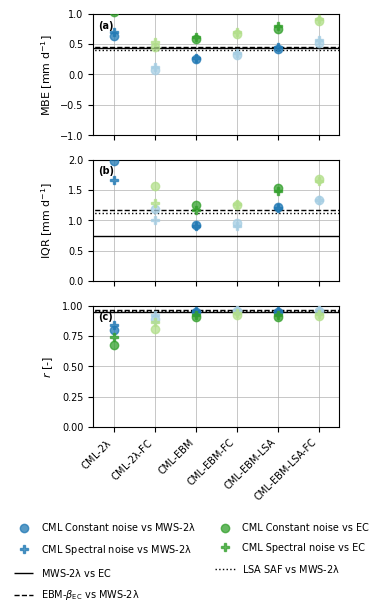

In [187]:
df_Nokia_meteo['RAIN_30min'] = df_Nokia_meteo['Cabauw:RAIN']*3
df_Nokia_meteo['RAIN_30min_prev'] = df_Nokia_meteo['RAIN_30min'].shift(1)
df_Nokia_meteo['RAIN_30min_prev2'] = df_Nokia_meteo['RAIN_30min'].shift(2)
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min_prev']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min_prev2']>0.1/2] = np.nan

df_Nokia_meteo[['Nokia_HPF_noise','Nokia_var_corr']].loc['2023-09-25 11:00':'2023-09-25 15:00'] = np.nan
df_Nokia_meteo['2Beam:LvE_Nokia_HPF_noise'] = df_Nokia_meteo['2Beam:LvE_CML1']
df_Nokia_meteo['2Beam:LvE_Nokia_var_corr'] = df_Nokia_meteo['2Beam:LvE_CML2']
df_Nokia_meteo['2Beam_FC:LvE_Nokia_HPF_noise'] = df_Nokia_meteo['2Beam_FC:LvE_CML1']
df_Nokia_meteo['2Beam_FC:LvE_Nokia_var_corr'] = df_Nokia_meteo['2Beam_FC:LvE_CML2']
df_Nokia_meteo['2Beam:H_Nokia_HPF_noise'] = df_Nokia_meteo['2Beam:H_CML1']
df_Nokia_meteo['2Beam:H_Nokia_var_corr'] = df_Nokia_meteo['2Beam:H_CML2']
df_Nokia_meteo['2Beam_FC:H_Nokia_HPF_noise'] = df_Nokia_meteo['2Beam_FC:H_CML1']
df_Nokia_meteo['2Beam_FC:H_Nokia_var_corr'] = df_Nokia_meteo['2Beam_FC:H_CML2']

methods = ['2Beam','EBM','EBM_LSA']
methods_label = [r'CML-$2\mathrm{\lambda}$',r'CML-$2\mathrm{\lambda}$-FC','CML-EBM','CML-EBM-FC','CML-EBM-LSA','CML-EBM-LSA-FC']#,'LSA-$\\beta$']#,'MWS-LAS vs EC']

props = dict(boxstyle='round', facecolor='white',edgecolor='tab:blue', alpha=0.5, pad = 0.6)
colors = ['#1f78b4','#a6cee3','#33a02c','#b2df8a']
alpha = 0.75
plot_offset = 0.25

def stats(x,y):
    corr,_ = pearsonr(y.values,x.values)
    iq = np.quantile(y.values-x.values,0.9) - np.quantile(y.values-x.values,0.1)
    bias = np.mean(y.values-x.values)
    return corr,iq,bias

def daily(df,x,y):
    rho_water = 1000 #kg m-3
    # print(df['2023-09-24'])
    # print((100/df['Lv'].values[0])/rho_water*1800*1000)
    df[x] = (df[x]/df['Lv'])/rho_water*1800*1000
    df[y] = (df[y]/df['Lv'])/rho_water*1800*1000
    df = df[[x,y]]
    df = df.dropna(axis=0,how='any')#.resample('1D',label='left',closed='right').sum()
    df = df.resample('1D',label='left',closed='right').sum()
    df.loc[(df[x] == 0) & (df[y] == 0)] = np.nan
    df = df.dropna(axis=0,how='any')
    return df

#100 Wm-2 equals 0.07 mm per half our
##############################################
#Latent heat flux
##############################################

fig,[ax1,ax2,ax3] = plt.subplots(ncols = 1,nrows=3,figsize = (8/2.54,15/2.54),sharex=True)

var_MWS = 'LvE_MWS'
var_EC = 'LEED'
for i in range(0,len(methods)):
    for j in range(0,2):
        if j == 0:
            y_var_indep = methods[i]+':LvE_Nokia_HPF_noise'
            y_var_dep = methods[i]+':LvE_Nokia_var_corr'
            offset = -1*plot_offset
            c = 0
        else:
            y_var_indep = methods[i]+'_FC:LvE_Nokia_HPF_noise'
            y_var_dep = methods[i]+'_FC:LvE_Nokia_var_corr'
            offset = plot_offset
            c = 1
            
        df_plot = df_Nokia_meteo[['2Beam:'+var_MWS,y_var_indep,'Lv']].apply(pd.to_numeric)
        df_plot = daily(df_plot,'2Beam:'+var_MWS,y_var_indep)
        x,y = df_plot['2Beam:'+var_MWS],df_plot[y_var_indep]
        corr,iq,bias = stats(x,y)
        ax1.plot(i+offset,bias,marker = 'o',lw = 0,color = colors[0+c],alpha=alpha,zorder=4)
        ax2.plot(i+offset,iq,marker = 'o',lw = 0,color = colors[0+c],alpha=alpha,zorder=4)
        ax3.plot(i+offset,corr,marker = 'o',lw = 0,color = colors[0+c],alpha=alpha,zorder=4)

        df_plot = df_Nokia_meteo[['Cabauw:'+var_EC,y_var_indep,'Lv']].apply(pd.to_numeric)
        df_plot = daily(df_plot,'Cabauw:'+var_EC,y_var_indep)
        x,y = df_plot['Cabauw:'+var_EC],df_plot[y_var_indep]
        corr,iq,bias = stats(x,y)
        ax1.plot(i+offset,bias,marker = 'o',lw = 0,color = colors[2+c],alpha=alpha,zorder=4)
        ax2.plot(i+offset,iq,marker = 'o',lw = 0,color = colors[2+c],alpha=alpha,zorder=4)
        ax3.plot(i+offset,corr,marker = 'o',lw = 0,color = colors[2+c],alpha=alpha,zorder=4)

        df_plot = df_Nokia_meteo[['2Beam:'+var_MWS,y_var_dep,'Lv']].apply(pd.to_numeric)
        df_plot = daily(df_plot,'2Beam:'+var_MWS,y_var_dep)
        x,y = df_plot['2Beam:'+var_MWS],df_plot[y_var_dep]
        corr,iq,bias = stats(x,y)
        ax1.plot(i+offset,bias,marker = 'P',lw = 0,color = colors[0+c],alpha=alpha,zorder=4)
        ax2.plot(i+offset,iq,marker = 'P',lw = 0,color = colors[0+c],alpha=alpha,zorder=4)
        ax3.plot(i+offset,corr,marker = 'P',lw = 0,color = colors[0+c],alpha=alpha,zorder=4)

        df_plot = df_Nokia_meteo[['Cabauw:'+var_EC,y_var_dep,'Lv']].apply(pd.to_numeric)
        df_plot = daily(df_plot,'Cabauw:'+var_EC,y_var_dep)
        x,y = df_plot['Cabauw:'+var_EC],df_plot[y_var_dep]
        corr,iq,bias = stats(x,y)
        ax1.plot(i+offset,bias,marker = 'P',lw = 0,color = colors[2+c],alpha=alpha,zorder=4)
        ax2.plot(i+offset,iq,marker = 'P',lw = 0,color = colors[2+c],alpha=alpha,zorder=4)
        ax3.plot(i+offset,corr,marker = 'P',lw = 0,color = colors[2+c],alpha=alpha,zorder=4)


ax3.plot(-5,-5,marker = 'o',lw = 0,color= colors[0],alpha=alpha,label = 'CML Constant noise vs MWS-$2\mathrm{\lambda}$')
ax3.plot(-5,-5,marker = 'P',lw = 0,color= colors[0],alpha=alpha,label = 'CML Spectral noise vs MWS-$2\mathrm{\lambda}$')
ax3.hlines(-10,-500,500,lw=1,ls='-',color='k',label = 'MWS-$2\mathrm{\lambda}$ vs EC')
ax3.hlines(-10,-500,500,lw=1,ls='--',color='k',label = r'EBM-$\beta_{\mathrm{EC}}$ vs MWS-$2\mathrm{\lambda}$')
ax3.plot(-5,-5,marker = 'o',lw = 0,color= colors[2],alpha=alpha,label = 'CML Constant noise vs EC')
ax3.plot(-5,-5,marker = 'P',lw = 0,color= colors[2],alpha=alpha,label = 'CML Spectral noise vs EC')
ax3.hlines(-10,-500,500,lw=1,ls=':',color='k',label = r'LSA SAF vs MWS-$2\mathrm{\lambda}$')


df_plot = df_Nokia_meteo[['2Beam:'+var_MWS,'Cabauw:'+var_EC,'Lv']].apply(pd.to_numeric)
df_plot = daily(df_plot,'2Beam:'+var_MWS,'Cabauw:'+var_EC)
y,x = df_plot['2Beam:'+var_MWS],df_plot['Cabauw:'+var_EC]
corr,iq,bias = stats(x,y)
ax1.hlines(bias,-500,500,lw=1,ls='-',color='k',zorder=3)
ax2.hlines(iq,-500,500,lw=1,ls='-',color='k',zorder=3)
ax3.hlines(corr,-500,500,lw=1,ls='-',color='k',zorder=3)

df_plot = df_Nokia_meteo[['2Beam:'+var_MWS,'Cabauw:LvE_Bowen','Lv']].apply(pd.to_numeric)
df_plot = daily(df_plot,'2Beam:'+var_MWS,'Cabauw:LvE_Bowen')
x,y = df_plot['2Beam:LvE_MWS'],df_plot['Cabauw:LvE_Bowen']
corr,iq,bias = stats(x,y)
ax1.hlines(bias,-500,500,lw=1,ls='--',color='k',zorder=3)
ax2.hlines(iq,-500,500,lw=1,ls='--',color='k',zorder=3)
ax3.hlines(corr,-500,500,lw=1,ls='--',color='k',zorder=3)

df_plot = df_Nokia_meteo[['2Beam:'+var_MWS,'LSA:LvE','Lv']].apply(pd.to_numeric)
df_plot = daily(df_plot,'2Beam:'+var_MWS,'LSA:LvE')
x,y = df_plot['2Beam:LvE_MWS'],df_plot['LSA:LvE']
corr,iq,bias = stats(x,y)
ax1.hlines(bias,-500,500,lw=1,ls=':',color='k',zorder=3)
ax2.hlines(iq,-500,500,lw=1,ls=':',color='k',zorder=3)
ax3.hlines(corr,-500,500,lw=1,ls=':',color='k',zorder=3)

ax1.set_ylabel(r'MBE [$\mathrm{mm}$ $\mathrm{d}^{-1}$]',fontsize=8)
ax2.set_ylabel(r'IQR [$\mathrm{mm}$ $\mathrm{d}^{-1}$]',fontsize=8)
ax3.set_ylabel(r'$r$ [-]',fontsize=8)
ax1.set_ylim(-1,1)
ax2.set_ylim(0,2)
ax3.set_ylim(0,1)
ax3.set_yticks([0,.25,0.5,0.75,1])

for i in [ax1,ax2,ax3]:
    i.grid(lw=0.5)
    i.tick_params(labelsize=7)

ax3.set_xlim(-0.5,2.5)
ax3.set_xticks([0-offset,0+offset,1-offset,1+offset,2-offset,2+offset])
ax3.set_xticklabels(methods_label,rotation = 45,ha = 'right')


ax1.text(0.02, 0.88, '(a)', transform=ax1.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
ax2.text(0.02, 0.88, '(b)', transform=ax2.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
ax3.text(0.02, 0.88, '(c)', transform=ax3.transAxes, fontsize=7,fontweight='semibold',zorder=11) 


plt.subplots_adjust(left = 0.2,right=0.98,top = 0.98,bottom = 0.28,wspace=0.3,hspace = 0.2)
ax3.legend(bbox_to_anchor=(0.4,-0.7),fontsize=7,loc='upper center',ncol = 2,labelspacing = 1,frameon=False)
fig.align_ylabels()
# plt.show()
# save_figure('Figures/Evaporation_computation/Statistics_LvE_daily',2400)
save_figure_pdf('Figures/Evaporation_computation/Statistics_LvE_daily')

# Plotting Around

## Net radiation

In [4]:
# path_to_KNMI = 'KNMI/Test/'
start_time, end_time = '2023-09-11 00:00','2024-10-01 00:00'

#Open KNMI data
df_meteo = pd.read_pickle(path_to_proc_KNMI_data+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'_CAMS_ERA5_CC_FG0_shift_15_11.pkl')
df_meteo['Cabauw:Bowen'] = df_meteo['Cabauw:HSON']/df_meteo['Cabauw:LEED']
df_meteo['LSA:Bowen'] = df_meteo['LSA:H']/df_meteo['LSA:LvE']
df_meteo['ERA5:Bowen'] = df_meteo['ERA5:msshf']/df_meteo['ERA5:mslhf']
df_meteo['Cabauw:R_net'] = df_meteo['Cabauw:SWD']+df_meteo['Cabauw:LWD']-df_meteo['Cabauw:SWU']-df_meteo['Cabauw:LWU']#-df_meteo['Cabauw:FG0']
df_meteo['LSA:R_net'] = df_meteo['LSA:SWD']+df_meteo['LSA:LWD']-df_meteo['LSA:SWU']-df_meteo['LSA:LWU']
print(sorted(list(df_meteo.keys())))

['CAMS:BHI', 'CAMS:CLEAR_SKY_BHI', 'CAMS:Cloud_cover', 'CAMS:DHI', 'CAMS:GHI', 'Cabauw:Bowen', 'Cabauw:D010', 'Cabauw:F010', 'Cabauw:FG0', 'Cabauw:FG0_shift', 'Cabauw:HSON', 'Cabauw:LEED', 'Cabauw:LWD', 'Cabauw:LWU', 'Cabauw:P0', 'Cabauw:Q002', 'Cabauw:QNBAL', 'Cabauw:RAIN', 'Cabauw:RH002', 'Cabauw:R_net', 'Cabauw:SWD', 'Cabauw:SWU', 'Cabauw:TA000', 'Cabauw:TA002', 'Cabauw:TD002', 'Cabauw:USTAB', 'Cabauw:USTED', 'Cabauw:USTPR', 'Cabauw:WTV', 'Cabauw:ZMA', 'Cabauw:q_calc', 'Cabauw:rho', 'ERA5:Bowen', 'ERA5:L_Ob', 'ERA5:d2m', 'ERA5:ie', 'ERA5:metss', 'ERA5:mntss', 'ERA5:mslhf', 'ERA5:msshf', 'ERA5:sp', 'ERA5:t2m', 'ERA5:u10', 'ERA5:v10', 'ERA5:zust', 'LSA:AL-BB-DH', 'LSA:Bowen', 'LSA:H', 'LSA:LST', 'LSA:LWD', 'LSA:LWU', 'LSA:LvE', 'LSA:R_net', 'LSA:SWD', 'LSA:SWU', 'LSA:albedo', 'LSA:emissivity']


                     Cabauw:R_net  LSA:R_net
2023-09-11 00:00:00    -38.187225 -29.659967
2023-09-11 00:30:00    -35.589111 -30.935794
2023-09-11 01:00:00    -35.176270 -35.476421
2023-09-11 01:30:00    -35.211548 -33.673297
2023-09-11 02:00:00    -35.425140 -14.867738
...                           ...        ...
2024-09-30 22:00:00     -6.623749 -18.361831
2024-09-30 22:30:00    -16.231812 -27.781571
2024-09-30 23:00:00     -5.689270 -18.403635
2024-09-30 23:30:00     -6.670685 -18.332046
2024-10-01 00:00:00     -3.713257 -18.007547

[18478 rows x 2 columns]


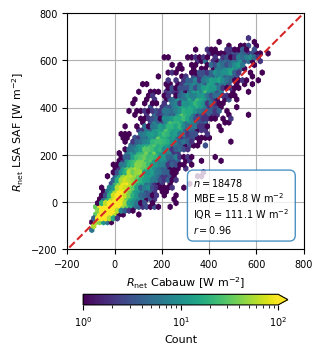

In [5]:
fig,ax1 = plt.subplots(ncols = 1,nrows=1,figsize = (8/2.54,9/2.54))

x_var = 'Cabauw:R_net'
y_var = 'LSA:R_net'

df_plot = df_meteo[[x_var,y_var]].dropna(axis=0,how='any')
print(df_plot)
x,y = df_plot[x_var].values,df_plot[y_var].values
hb = ax1.hexbin(x,y,gridsize=45,bins='log',vmin = 1,vmax=100,zorder=3)
corr,_ = pearsonr(y,x)
iq = np.quantile(y-x,0.9) - np.quantile(y-x,0.1)
bias = np.mean(y-x)
num = len(x)
textstr = '\n'.join((r'$n = $'+'{:.0f}'.format(num),r'$\mathrm{MBE} = $'+'{:.1f}'.format(bias)+' W m$^{-2}$',r'IQR = '+'{:.1f}'.format(iq)+' W m$^{-2}$',r'$r = $'+'{:.2f}'.format(corr)))                  
props = dict(boxstyle='round', facecolor='white',edgecolor='tab:blue', alpha=0.8, pad = 0.6)
ax1.text(0.94, 0.06, textstr, transform=ax1.transAxes, fontsize=7,verticalalignment='bottom',horizontalalignment='right',multialignment = 'left', bbox=props,zorder=6)
ax1.set_xlabel(r'$R_{\mathrm{net}}$ Cabauw [$\mathrm{W}$ $\mathrm{m}^{-2}$]',fontsize=8)
ax1.set_ylabel(r'$R_{\mathrm{net}}$ LSA SAF [$\mathrm{W}$ $\mathrm{m}^{-2}$]',fontsize=8)


for i in [ax1]:
    i.plot([-1000,1000],[-1000,1000],ls = '--',color = 'tab:red',label='1:1',zorder=6)
    i.grid(zorder=0)
    i.set_aspect('equal')
    i.tick_params(labelsize=7)
    i.set_xlim(-200,800)
    i.set_ylim(-200,800)

plt.subplots_adjust(left = 0.2,right = 0.95,top=0.98,bottom = 0.2)
cbar_ax = fig.add_axes([0.25, 0.1, 0.65, 0.03])
cbar = plt.colorbar(hb, cax=cbar_ax,extend = 'max',orientation = 'horizontal')
cbar.set_label(label = 'Count',size = 8)
cbar_ax.tick_params(labelsize=7)
plt.show()
# save_figure('Figures/Evaporation_computation/R_net_LSA_new',2400)
# save_figure_pdf('Figures/Evaporation_computation/R_net_LSA_new')

## Free convection vs complete scaling

In [6]:
cT1 = 5.6
cT2 = 6.5
cq1 = 4.5
cq2 = 7.3
cq2_low = 7.0
cq2_high = 7.7
cT2_low = 5.5
cT2_high = 7.6
karman = 0.4

#Computation of constants in FC equation
# z_L = -10000000000000000000000000
# f1 = cT1*(1-cT2*z_L)**(-2/3)
# f3 = cq1*(1-cq2*z_L)**(-2/3)

# constant_H = (karman**0.5)*((z_L*-1)**(-0.5))*(f1**(-3/4))
# constant_LvE = (karman**0.5)*((z_L*-1)**(-0.5))*(f1**(-3/4))*((f1/f3)**0.5)
# print(karman**0.5,(z_L*-1)**(-0.5),(f1**(-3/4)),((f1/f3)**0.5))
# print(constant_H,constant_LvE)

f_H_list = []
f_LvE_list = []
f_LvE_list_low = []
f_LvE_list_high = []
f_H_list_low = []
f_H_list_high = []
L_list = []
zL_list = []
for i in np.logspace(-2,1):
    f_Hfc = ((1-cT2*(-1*i))/(-cT2*(-1*i)))**(1/3)
    f_LvEfc = ((1-cq2*(-1*i))/(-cq2*(-1*i)))**(1/3)
    f_LvEfc_low = ((1-cq2_low*(-1*i))/(-cq2_low*(-1*i)))**(1/3)
    f_LvEfc_high = ((1-cq2_high*(-1*i))/(-cq2_high*(-1*i)))**(1/3)
    f_Hfc_low = ((1-cT2_low*(-1*i))/(-cT2_low*(-1*i)))**(1/3)
    f_Hfc_high = ((1-cT2_high*(-1*i))/(-cT2_high*(-1*i)))**(1/3)
    f_H_list.append(1/f_Hfc)
    f_LvE_list.append(1/f_LvEfc)
    f_LvE_list_low.append(1/f_LvEfc_low)
    f_LvE_list_high.append(1/f_LvEfc_high)
    f_H_list_low.append(1/f_Hfc_low)
    f_H_list_high.append(1/f_Hfc_high)
    zL_list.append(i)
    L_list.append(-1*(i/10)**-1)

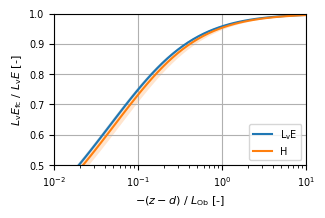

In [10]:
fig,ax = plt.subplots(figsize = (8/2.54,5/2.54))

# ax.semilogx(zL_list,f_LvE_list,label = 'H')
ax.semilogx(zL_list,f_LvE_list,label = r'L$_{\mathrm{v}}$E')
ax.fill_between(zL_list,y1 = f_LvE_list_low,y2= f_LvE_list_high, color = 'tab:blue',alpha=0.2,zorder=4,ec=None)
ax.semilogx(zL_list,f_H_list,label = 'H')
ax.fill_between(zL_list,y1 = f_H_list_low,y2= f_H_list_high, color = 'tab:orange',alpha=0.2,ec=None)
# ax.semilogx(zL_2_list,f_LvE_list)
ax.set_ylabel(r'$L_{\mathrm{v}}E_{\mathrm{fc}}$ / $L_{\mathrm{v}}E$ [-]',fontsize=8)
ax.set_xlabel('$-(z-d)$ / $L_{\mathrm{Ob}}$ [-]',fontsize=8)
ax.grid()
ax.set_xlim(0.01,10)
ax.set_ylim(0.5,1)
ax.tick_params(labelsize=7)
ax.legend(loc=4,fontsize=7)
# plt.show()
plt.subplots_adjust(left=0.15,right=0.95,top=0.97,bottom=0.2)
# plt.show()
save_figure_pdf('Figures/Evaporation_computation/Normal_vs_free_conv')

# KNMI Data

In [ ]:
import logging
import sys
from datetime import datetime

import requests

logging.basicConfig()
logger = logging.getLogger(__name__)
logger.setLevel("INFO")

api_url = "https://api.dataplatform.knmi.nl/open-data"
api_version = "v1"

date_start, date_end = '2024-07-02','2024-10-01'
timestamp_start,timestamp_end = datetime.strftime(pd.to_datetime(date_start),"%Y%m%d"),datetime.strftime(pd.to_datetime(date_end),"%Y%m%d")
date_range = pd.date_range(start = timestamp_start,end = timestamp_end,freq = 'd').strftime("%Y%m%d")
print(date_range)
path_to_KNMI_data = 'KNMI/'
        
    

def main():
    # Parameters
    api_key = "eyJvcmciOiI1ZTU1NGUxOTI3NGE5NjAwMDEyYTNlYjEiLCJpZCI6ImYwNjk1Y2E0ZWI1NzRmYTY4YWM4MWRjODY5MmE3MjliIiwiaCI6Im11cm11cjEyOCJ9"
    dataset_names = ['cesar_surface_flux_la1_t10',"cesar_surface_radiation_la1_t10",'cesar_surface_meteo_la1_t10']#,'cesar_surface_flux_la1_t10']# [ceilonet_chm15k_backsct_la1_t05]
    dataset_version = "v1.0"
    for j in range(0,len(dataset_names)):
        dataset_name = dataset_names[j]
        # print(dataset_name)
        for i in range(0,len(date_range)):
            # Use list files request to request first 10 files of the day.
            start_after_filename_prefix = f"{dataset_name}_{dataset_version}_{date_range[i]}"
            print(start_after_filename_prefix)
            list_files_response = requests.get(
                f"{api_url}/{api_version}/datasets/{dataset_name}/versions/{dataset_version}/files",
                headers={"Authorization": api_key},
                params={"startAfterFilename": start_after_filename_prefix},
            )
            list_files = list_files_response.json()

            # logger.info(f"List files response:\n{list_files}")
            dataset_files = list_files.get("files")
            # Retrieve first file in the list files response
            filename = dataset_files[0].get("filename")
            # logger.info(f"Retrieve file with name: {filename}")
            endpoint = f"{api_url}/{api_version}/datasets/{dataset_name}/versions/{dataset_version}/files/{filename}/url"
            get_file_response = requests.get(endpoint, headers={"Authorization": api_key})
            if get_file_response.status_code != 200:
                logger.error("Unable to retrieve download url for file")
                logger.error(get_file_response.text)
                sys.exit(1)

            download_url = get_file_response.json().get("temporaryDownloadUrl")
            download_file_from_temporary_download_url(download_url, filename)


def download_file_from_temporary_download_url(download_url, filename):
    try:
        with requests.get(download_url, stream=True) as r:
            r.raise_for_status()
            with open(path_to_KNMI_data+filename, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
    except Exception:
        logger.exception("Unable to download file using download URL")
        sys.exit(1)

    # logger.info(f"Successfully downloaded dataset file to {filename}")


if __name__ == "__main__":
    main()


In [10]:
path_to_KNMI_data = 'KNMI/'########Check path!
path_to_proc_KNMI_data = 'KNMI/Processed/' ########Check path!
start_time, end_time = '2023-09-11 00:00','2024-10-01 00:00'
dataset_names = ['cesar_surface_flux_la1_t10',"cesar_surface_radiation_la1_t10",'cesar_surface_meteo_la1_t10']#,'cesar_surface_flux_la1_t10']
dataset_version = "v1.0"
df_total_rad = pd.DataFrame()
df_total_met = pd.DataFrame()
df_total_flux = pd.DataFrame()
df_cloud = pd.DataFrame()
files = sorted(os.listdir(path_to_KNMI_data))
# print(files)
for j in range(0,len(dataset_names)):
    print(dataset_names[j])
    if dataset_names[j] == 'ceilonet_chm15k_backsct_la1_t05':
        string_prefix = dataset_names[j]+'_'+dataset_version+'_06348_A'
    else:    
        string_prefix = dataset_names[j]+'_'+dataset_version+'_'
    start_file, end_file = string_prefix+datetime.strftime(pd.to_datetime(start_time),"%Y%m%d")+'.nc', string_prefix+datetime.strftime(pd.to_datetime(end_time),"%Y%m%d")+'.nc'
    start_index, end_index = files.index(start_file),files.index(end_file)
    
    for i in files[start_index:end_index]:
        start_date = datetime.strptime(i[-11:-3], '%Y%m%d')
        # print(start_date)
        ds = xr.open_dataset(path_to_KNMI_data+i)
        time_axis = pd.date_range(start=start_date,periods = ds.sizes['time'],freq = '10min')
        time_axis_cloud = pd.date_range(start=start_date,periods = ds.sizes['time'],freq = '5min')+pd.Timedelta(5, 'minutes')
        if dataset_names[j] ==  "cesar_surface_radiation_la1_t10":
            ds = ds[['LWD','LWU','SWD','SWU']]
            df = ds.to_dataframe()
            df['Date'] = time_axis
            df.set_index('Date',inplace=True)            
            df_total_rad = pd.concat([df_total_rad,df],axis = 0)
        elif dataset_names[j] == 'cesar_surface_meteo_la1_t10':
            ds = ds[['D010','F010','P0','RAIN','RH002','Q002','TA002','TA000','TD002','ZMA']]
            df = ds.to_dataframe()
            df['Date'] = time_axis
            df.set_index('Date',inplace=True)   
            df_total_met = pd.concat([df_total_met,df],axis = 0)
        elif dataset_names[j] == 'cesar_surface_flux_la1_t10':
            ds = ds[['HSON','LEED','USTAB','USTED','USTPR','WTV','FG0','QNBAL']]
            df = ds.to_dataframe()
            df['Date'] = time_axis
            df.set_index('Date',inplace=True)   
            df_total_flux = pd.concat([df_total_flux,df],axis = 0)
df_total = pd.concat([df_total_met,df_total_rad,df_total_flux,df_cloud],axis=1)
# print(df_total)
df_total.to_pickle(path_to_proc_KNMI_data+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'_09_10.pkl')

cesar_surface_flux_la1_t10
cesar_surface_radiation_la1_t10
cesar_surface_meteo_la1_t10


## LSA SAF data

In [38]:
start_time, end_time = '2023-09-11 00:00','2024-10-01 00:00'

#Open KNMI data
df_meteo = pd.read_pickle(path_to_KNMI+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'_09_10.pkl')
df_meteo['FG0_shift'] = df_meteo['FG0'].shift(-6,freq='10min')
df_met_mean = df_meteo.resample('30min',label='right',closed='right').mean()
df_met_mean['RAIN'] = df_met_mean['RAIN']*3 #To make up for averaging
df_met_mean['q_calc'] = spec_humidity(vapor_pressure(df_met_mean['TA002'],df_met_mean['RH002']),df_met_mean['P0']*100)/1000 #kg kg-1
df_met_mean['rho'] = density(vapor_pressure(df_met_mean['TA002'],df_met_mean['RH002']),df_met_mean['P0']*100,df_met_mean['TA002'])
df_met_mean = df_met_mean.add_prefix('Cabauw:')


#Open LSA SAF data
df_albedo = pd.read_csv(path_to_LSASAF+'albedo.csv',index_col = 'time',parse_dates = True)#.asfreq(freq='30min',method='ffill')
df_emissivity = pd.read_csv(path_to_LSASAF+'emissivity_new1.csv',index_col = 'time',parse_dates = True)#.interpolate(method='linear', axis=0).asfreq(freq='30min',method='ffill')
df_albedo['emissivity'] = df_emissivity.values
df_albedo = df_albedo.asfreq(freq='30min',method='ffill') #Day timestamp refers to day ahead --> forward fill
df_albedo.rename(columns = {'AL-BB-BH':'albedo'},inplace=True)
df_LST = pd.read_csv(path_to_LSASAF+'LST.csv',index_col = 'time',parse_dates = True)
df_LST.rename(columns = {'MLST-AS':'LST'},inplace=True)
df_LST['LST'] += 273.15
df_LvE = pd.read_csv(path_to_LSASAF+'LvE.csv',index_col = 'time',parse_dates = True)
df_LvE.rename(columns = {'MLE':'LvE'},inplace=True)
df_H = pd.read_csv(path_to_LSASAF+'H.csv',index_col = 'time',parse_dates = True)
df_H.rename(columns = {'MH':'H'},inplace=True)
df_LWD = pd.read_csv(path_to_LSASAF+'LWD.csv',index_col = 'time',parse_dates = True)
df_LWD.rename(columns = {'DSLF':'LWD'},inplace=True)
df_SWD = pd.read_csv(path_to_LSASAF+'SWD.csv',index_col = 'time',parse_dates = True).resample('30min',label='right',closed='right').mean()
df_SWD.rename(columns = {'DSSF_TOT':'SWD'},inplace=True)
df_LSA = pd.merge(df_albedo,df_LST,how = 'outer',left_index=True,right_index=True)
df_LSA = pd.merge(df_LSA,df_LWD,how = 'outer',left_index=True,right_index=True)
df_LSA = pd.merge(df_LSA,df_SWD,how = 'outer',left_index=True,right_index=True)
df_LSA = pd.merge(df_LSA,df_LvE,how = 'outer',left_index=True,right_index=True)
df_LSA = pd.merge(df_LSA,df_H,how = 'outer',left_index=True,right_index=True)

df_LSA['LWU'] = df_LSA['emissivity']*SB*df_LSA['LST']**4 + (1-df_LSA['emissivity'])*df_LSA['LWD']
df_LSA['SWU'] = df_LSA['albedo']*df_LSA['SWD']
df_LSA = df_LSA.add_prefix('LSA:')

#Merge and save data
df_merge = pd.merge(df_merge,df_LSA,how = 'outer',left_index=True,right_index=True)[start_time:end_time]
df_merge.to_pickle(path_to_proc_KNMI_data+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'_CAMS_ERA5_CC_FG0_shift_15_11.pkl')
